In [1]:
import glob, os, sys
import uproot, ROOT, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, roc_auc_score, auc
import h5py
import onnxruntime as ort
sys.path.append("..")
from utils.utils import *

Welcome to JupyROOT 6.30/04


In [16]:
# path = '/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/mc/ditau_hh/'
path = '/global/homes/a/agarabag/pscratch/ditdau_samples/test/T01/mc/ditau_hh/'

# jz_patterns = ['mc20d/nom/user.ademaria.Htt*JZ*', 'mc20a/nom/user.ademaria.Htt*JZ*', 'mc20e/nom/user.ademaria.Htt*JZ*']
# ggh_patterns = ['mc20d/nom/user.ademaria.Htt*ggH*', 'mc20a/nom/user.ademaria.Htt*ggH*', 'mc20e/nom/user.ademaria.Htt*ggH*']
# jz_patterns = ['mc20d/nom/user.ademaria.Htt*JZ*']
jz_patterns = ['mc20d/nom/user.*Sh_2211*']
ggh_patterns = ['mc20d/nom/user.ademaria.Htt*ggH*']
# Collect all .root files matching the patterns
jz_files = []
for pattern in jz_patterns:
    full_pattern = os.path.join(path, pattern, '*.root')
    jz_files.extend(glob.glob(full_pattern))

ggh_files = []
for pattern in ggh_patterns:
    full_pattern = os.path.join(path, pattern, '*.root')
    ggh_files.extend(glob.glob(full_pattern))  



In [17]:
# omni_scores = []
# bdt_scores = []

# # Read each .root file and extract the variables
# for file in files:
#     with uproot.open(file) as f:
#         tree = f["CollectionTree"]  # Replace "tree_name" with the actual name of the tree
#         omni_scores.extend(tree["omni_score"].array())
#         bdt_scores.extend(tree["ditau_BDTScore"].array())

# # Convert lists to numpy arrays
# omni_scores = np.array(omni_scores)
# bdt_scores = np.array(bdt_scores)

In [18]:

# Initialize lists for all required variables
event_numbers = []
bdt_scores = []
omni_scores = []
subl_n_core_tracks = []
lead_n_core_tracks = []
ditau_pt_values = []
n_subjets = []
lead_subjet_charge = []
subl_subjet_charge = []
n_tracks = []
n_bjets = []

# Read each .root file and extract the variables
for file in jz_files:
    with uproot.open(file) as f:
        tree = f["NOMINAL"]  # Replace "NOMINAL" with the actual name of the tree
        
        # Extract all the required variables
        event_numbers.extend(tree["event_number"].array())
        bdt_scores.extend(tree["ditau_obj_bdt_score"].array())
        omni_scores.extend(tree["ditau_obj_omni_score"].array())
        subl_n_core_tracks.extend(tree["ditau_obj_subleadsubjet_n_core_tracks"].array())
        lead_n_core_tracks.extend(tree["ditau_obj_leadsubjet_n_core_tracks"].array())
        n_subjets.extend(tree["ditau_obj_nSubjets"].array())
        lead_subjet_charge.extend(tree["ditau_obj_leadsubjet_charge"].array())
        subl_subjet_charge.extend(tree["ditau_obj_subleadsubjet_charge"].array())
        n_tracks.extend(tree["ditau_obj_n_tracks"].array())
        n_bjets.extend(tree["n_bjets_DL1dv01_FixedCutBEff_70"].array())
        
        ditau_p4 = vector.obj(px=tree['ditau_obj_p4'].array().fP.fX,
                               py=tree['ditau_obj_p4'].array().fP.fY,
                               pz=tree['ditau_obj_p4'].array().fP.fZ,
                               energy=tree['ditau_obj_p4'].array().fE)
        ditau_pt_values.extend(ditau_p4.pt)

# Convert lists to numpy arrays
event_numbers = np.array(event_numbers)
bdt_scores = np.array(bdt_scores)
omni_scores = np.array(omni_scores)
subl_n_core_tracks = np.array(subl_n_core_tracks)
lead_n_core_tracks = np.array(lead_n_core_tracks)
ditau_pt_values = np.array(ditau_pt_values)
n_subjets = np.array(n_subjets)
lead_subjet_charge = np.array(lead_subjet_charge)
subl_subjet_charge = np.array(subl_subjet_charge)
n_tracks = np.array(n_tracks)
n_bjets = np.array(n_bjets)

# Define the cut function exactly matching the provided general_cut
def apply_general_cut(ditau_id_cut):
    mask = (
        (lead_subjet_charge * subl_subjet_charge == -1) & 
        (n_bjets == 0) &
        (n_subjets >= 2) & 
        (((lead_n_core_tracks == 1) | (lead_n_core_tracks == 3)) &
        ((subl_n_core_tracks == 1) | (subl_n_core_tracks == 3))) & 
        (n_tracks - lead_n_core_tracks - subl_n_core_tracks == 0))
    
    
    # Apply the mask to filter the data
    return (
        event_numbers[mask],
        bdt_scores[mask],
        omni_scores[mask],
        subl_n_core_tracks[mask],
        lead_n_core_tracks[mask],
        ditau_pt_values[mask],
        n_subjets[mask],
        lead_subjet_charge[mask],
        subl_subjet_charge[mask],
        n_tracks[mask],
        n_bjets[mask]
    )

# Example of applying the cut
ditau_id_cut = 0.5  # Replace with your actual cut value
(filtered_event_numbers, 
 filtered_bdt_scores, 
 filtered_omni_scores, 
 filtered_subl_n_core_tracks, 
 filtered_lead_n_core_tracks, 
 filtered_ditau_pt_values,
 filtered_n_subjets,
 filtered_lead_subjet_charge,
 filtered_subl_subjet_charge,
 filtered_n_tracks,
 filtered_n_bjets) = apply_general_cut(ditau_id_cut)

In [19]:
# Initialize lists for all required variables
event_numbers_ggh = []
bdt_scores_ggh = []
omni_scores_ggh = []
subl_n_core_tracks_ggh = []
lead_n_core_tracks_ggh = []
ditau_pt_values_ggh = []
n_subjets_ggh = []
lead_subjet_charge_ggh = []
subl_subjet_charge_ggh = []
n_tracks_ggh = []
n_bjets_ggh = []

# Read each .root file and extract the variables
for file in ggh_files:
    with uproot.open(file) as f:
        tree = f["NOMINAL"]  # Replace "NOMINAL" with the actual name of the tree
        
        # Extract all the required variables
        event_numbers_ggh.extend(tree["event_number"].array())
        bdt_scores_ggh.extend(tree["ditau_obj_bdt_score"].array())
        omni_scores_ggh.extend(tree["ditau_obj_omni_score"].array())
        subl_n_core_tracks_ggh.extend(tree["ditau_obj_subleadsubjet_n_core_tracks"].array())
        lead_n_core_tracks_ggh.extend(tree["ditau_obj_leadsubjet_n_core_tracks"].array())
        n_subjets_ggh.extend(tree["ditau_obj_nSubjets"].array())
        lead_subjet_charge_ggh.extend(tree["ditau_obj_leadsubjet_charge"].array())
        subl_subjet_charge_ggh.extend(tree["ditau_obj_subleadsubjet_charge"].array())
        n_tracks_ggh.extend(tree["ditau_obj_n_tracks"].array())
        n_bjets_ggh.extend(tree["n_bjets_DL1dv01_FixedCutBEff_70"].array())
        
        ditau_p4_ggh = vector.obj(px=tree['ditau_obj_p4'].array().fP.fX,
                               pz=tree['ditau_obj_p4'].array().fP.fZ,
                               py=tree['ditau_obj_p4'].array().fP.fY,
                               energy=tree['ditau_obj_p4'].array().fE)
        ditau_pt_values_ggh.extend(ditau_p4_ggh.pt)

# Convert lists to numpy arrays
event_numbers_ggh = np.array(event_numbers_ggh)
bdt_scores_ggh = np.array(bdt_scores_ggh)
omni_scores_ggh = np.array(omni_scores_ggh)
subl_n_core_tracks_ggh = np.array(subl_n_core_tracks_ggh)
lead_n_core_tracks_ggh = np.array(lead_n_core_tracks_ggh)
ditau_pt_values_ggh = np.array(ditau_pt_values_ggh)
n_subjets_ggh = np.array(n_subjets_ggh)
lead_subjet_charge_ggh = np.array(lead_subjet_charge_ggh)
subl_subjet_charge_ggh = np.array(subl_subjet_charge_ggh)
n_tracks_ggh = np.array(n_tracks_ggh)
n_bjets_ggh = np.array(n_bjets_ggh)

# Define the cut function exactly matching the provided general_cut
def apply_general_cut_ggh(ditau_id_cut):
    mask = (
        (lead_subjet_charge_ggh * subl_subjet_charge_ggh == -1) & 
        (n_bjets_ggh == 0) &
        (n_subjets_ggh >= 2) & 
        (((lead_n_core_tracks_ggh == 1) | (lead_n_core_tracks_ggh == 3)) &
        ((subl_n_core_tracks_ggh == 1) | (subl_n_core_tracks_ggh == 3))) & 
        (n_tracks_ggh - lead_n_core_tracks_ggh - subl_n_core_tracks_ggh == 0))
    
    # Apply the mask to filter the data
    return (
        event_numbers_ggh[mask],
        bdt_scores_ggh[mask],
        omni_scores_ggh[mask],
        subl_n_core_tracks_ggh[mask],
        lead_n_core_tracks_ggh[mask],
        ditau_pt_values_ggh[mask],
        n_subjets_ggh[mask],
        lead_subjet_charge_ggh[mask],
        subl_subjet_charge_ggh[mask],
        n_tracks_ggh[mask],
        n_bjets_ggh[mask]
    )

# Example of applying the cut
ditau_id_cut = 0.5  # Replace with your actual cut value
(filtered_event_numbers_ggh, 
 filtered_bdt_scores_ggh, 
 filtered_omni_scores_ggh, 
 filtered_subl_n_core_tracks_ggh, 
 filtered_lead_n_core_tracks_ggh, 
 filtered_ditau_pt_values_ggh,
 filtered_n_subjets_ggh,
 filtered_lead_subjet_charge_ggh,
 filtered_subl_subjet_charge_ggh,
 filtered_n_tracks_ggh,
 filtered_n_bjets_ggh) = apply_general_cut_ggh(ditau_id_cut)

In [ ]:
# event_numbers = []
# bdt_scores = []
# omni_scores = []
# subl_n_core_tracks = []
# lead_n_core_tracks = []
# ditau_pt_values = []

# # Read each .root file and extract the variables
# for file in jz_files:
#     with uproot.open(file) as f:
#         tree = f["NOMINAL"]  # Replace "NOMINAL" with the actual name of the tree
        
#         # Extract the variables
#         event_numbers.extend(tree["event_number"].array())
#         bdt_scores.extend(tree["ditau_obj_bdt_score"].array())
#         omni_scores.extend(tree["ditau_obj_omni_score"].array())
#         subl_n_core_tracks.extend(tree["ditau_obj_subleadsubjet_n_core_tracks"].array())
#         lead_n_core_tracks.extend(tree["ditau_obj_leadsubjet_n_core_tracks"].array())   
#         ditau_p4 = vector.obj(px=tree['ditau_obj_p4'].array().fP.fX,
#                     py=tree['ditau_obj_p4'].array().fP.fY,
#                     pz=tree['ditau_obj_p4'].array().fP.fZ,
#                     energy=tree['ditau_obj_p4'].array().fE)  
#         ditau_pt_values.extend(ditau_p4.pt)

# # Convert lists to numpy arrays
# event_numbers = np.array(event_numbers)
# bdt_scores = np.array(bdt_scores)
# omni_scores = np.array(omni_scores)
# subl_n_core_tracks = np.array(subl_n_core_tracks)
# lead_n_core_tracks = np.array(lead_n_core_tracks)
# ditau_pt_values = np.array(ditau_pt_values)
# label = np.zeros(len(event_numbers))

In [ ]:
# # bow for ggh
# event_numbers_ggh = []
# bdt_scores_ggh = []
# omni_scores_ggh = []
# subl_n_core_tracks_ggh = []
# lead_n_core_tracks_ggh = []
# ditau_pt_values_ggh = []

# # Read each .root file and extract the variables
# for file in ggh_files:
#     with uproot.open(file) as f:
#         tree = f["NOMINAL"]  # Replace "NOMINAL" with the actual name of the tree
        
#         # Extract the variables
#         event_numbers_ggh.extend(tree["event_number"].array())
#         bdt_scores_ggh.extend(tree["ditau_obj_bdt_score"].array())
#         omni_scores_ggh.extend(tree["ditau_obj_omni_score"].array())
#         subl_n_core_tracks_ggh.extend(tree["ditau_obj_subleadsubjet_n_core_tracks"].array())
#         lead_n_core_tracks_ggh.extend(tree["ditau_obj_leadsubjet_n_core_tracks"].array())   
#         ditau_p4_ggh = vector.obj(px=tree['ditau_obj_p4'].array().fP.fX,
#                     py=tree['ditau_obj_p4'].array().fP.fY,
#                     pz=tree['ditau_obj_p4'].array().fP.fZ,
#                     energy=tree['ditau_obj_p4'].array().fE)  
#         ditau_pt_values_ggh.extend(ditau_p4_ggh.pt)

# # Convert lists to numpy arrays
# event_numbers_ggh = np.array(event_numbers_ggh)
# bdt_scores_ggh = np.array(bdt_scores_ggh)
# omni_scores_ggh = np.array(omni_scores_ggh)
# subl_n_core_tracks_ggh = np.array(subl_n_core_tracks_ggh)
# lead_n_core_tracks_ggh = np.array(lead_n_core_tracks_ggh)
# ditau_pt_values_ggh = np.array(ditau_pt_values_ggh)
# label_ggh = np.ones(len(event_numbers_ggh))

In [21]:
df1 = pd.DataFrame({
    'event_weight': event_numbers,
    'weight': event_numbers,
    'bdt_score_new': bdt_scores,
    'omni_probs': omni_scores,
    'n_tracks_subl': subl_n_core_tracks,
    'n_tracks_lead': lead_n_core_tracks,
    'ditau_pt': ditau_pt_values*1e3,
    'eta': ditau_pt_values,
    'average_mu': ditau_pt_values,
    # 'label': label,
    'type': 'regular'
})

# GGH data
df2 = pd.DataFrame({
    'event_weight': event_numbers_ggh,
    'weight': event_numbers_ggh,
    'bdt_score_new': bdt_scores_ggh,
    'omni_probs': omni_scores_ggh,
    'n_tracks_subl': subl_n_core_tracks_ggh,
    'n_tracks_lead': lead_n_core_tracks_ggh,
    'ditau_pt': ditau_pt_values_ggh*1e3,
    'eta': ditau_pt_values_ggh,
    'average_mu': ditau_pt_values_ggh,
    # 'label': label_ggh,
    'type': 'ggh'
})

# Combine DataFrames
df = pd.concat([df1, df2], ignore_index=True)


# Save to CSV
# csv_path = '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/test.csv'
# df.to_csv(csv_path, index=False)

Text(0, 0.5, 'Frequency')

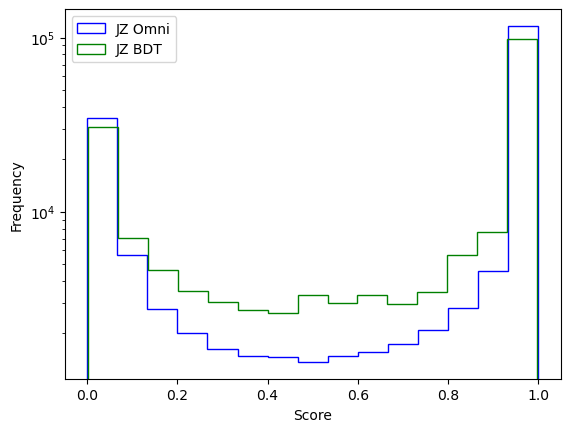

In [20]:
plt.hist(filtered_omni_scores, bins=15, color='blue', label='JZ Omni', histtype='step')
plt.hist(filtered_bdt_scores, bins=15, color='green', label='JZ BDT', histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

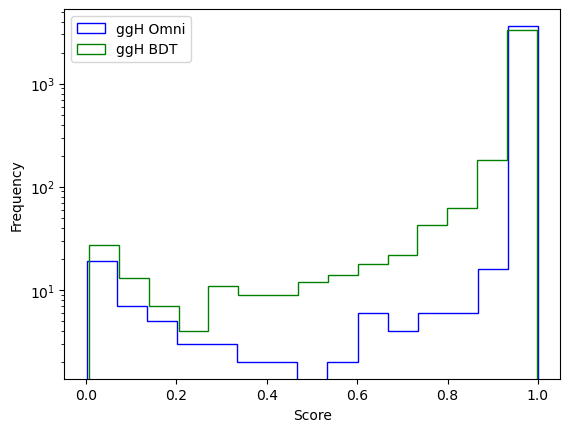

In [21]:
plt.hist(filtered_omni_scores_ggh, bins=15, color='blue', label='ggH Omni', histtype='step')
plt.hist(filtered_bdt_scores_ggh, bins=15, color='green', label='ggH BDT', histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Frequency')

In [2]:
# def signal_cut(df_chunk):
#     cut1 = (df_chunk['IsTruthHadronic']==1)
#     cut2 = (df_chunk['n_subjets'] >=2)
#     cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
#     cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
#     return (cut1 & cut2 & cut3 & cut4)
    
# def bkg_cut(df_chunk):
#     cut1 = (df_chunk['n_subjets'] >=2)
#     cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
#     cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
#     return (cut1 & cut2 & cut3)

# def h52panda(filelist, xs, cut, bkg=0):
#     combined = pd.DataFrame()
#     chunk_size = 10000000  # Adjust this size to suit your system's memory
#     pt_bins = np.linspace(200000, 1000000, 41)

#     dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
#                 "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
#                 "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
#                 "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
#                 "d0_leadtrack_lead", "d0_leadtrack_subl",
#                 "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
#                 "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta"]

#     for index in range(len(filelist)):
#         file_path = filelist[index]
    
#         # Process the file in chunks
#         with h5py.File(file_path, 'r') as h5_file:
#             # Determine the total length of the datasets
#             total_length = h5_file[dataset_keys[0]].shape[0]
#             print(f'{filelist[index]}: {total_length}')
#             print(len(h5_file["d0_leadtrack_subl"]), len(h5_file["lead_subjet_pt"]), len(h5_file["trackPt"]))
#             # Read and process each chunk
#             for chunk_start in range(0, total_length, chunk_size):
#                 chunk_end = chunk_start + chunk_size

#                 # Use slicing to read a chunk from each dataset in the HDF5 file
#                 data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

#                 # Convert the dictionary to a pandas DataFrame
#                 df_chunk = pd.DataFrame(data)

#                 # Apply Cut
#                 filtered_chunk = df_chunk[cut(df_chunk)]
#                 filtered_chunk = filtered_chunk.copy()
#                 filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

#                 combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
#     combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
#     combined['label'] = bkg
#     combined['weight'] = combined['event_weight'] * combined['pT_weight']

#     return combined

# path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"

# bkg_xs = [364701, 364702, 364703, 364704, 364705, 364706, 364707, 364708, 364709, 364710, 364711, 364712]
# signal_xs = [425108, 425100, 425101, 425102, 425103, 425104, 425105, 425106, 425107, 425200]
# # gamma_xs = [425200]

# # File Location. order maatch XS. 
# bkg_filelist = []
# for index in range(12):
#     bkg_filelist.append(path+f"jz_w_newbdt/dijet_flattened_jz{index}.h5")
# print(bkg_filelist)

# # signal_filelist = [path+"signal_w_newbdt/graviton_flattened_M1000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M1500.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M1750.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2250.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2500.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M3000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M4000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M5000.h5",
# #                 path+"signal_w_newbdt/gamma_flattened_0.h5"]

# # combined_signal = h52panda(signal_filelist, signal_xs, signal_cut, 1)
# combined_bkg = h52panda(bkg_filelist, mc23_jz_xs, bkg_cut, 0)

# comb_vh_signal = h52panda([path+"ntuple_flattened_VHtautau.h5"], [802168], signal_cut, 1)

In [6]:
def signal_cut(df_chunk):
    cut1 = (df_chunk['IsTruthHadronic']==1)
    cut2 = (df_chunk['n_subjets'] >=2)
    cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut4)
    
def bkg_cut(df_chunk):
    cut1 = (df_chunk['n_subjets'] >=2)
    cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    # cut4 = (df_chunk['event_weight'] < 1000)
    return (cut1 & cut3)

def h52panda(filelist, xs, cut, bkg=0):
    combined = pd.DataFrame()
    chunk_size = 10000000  # Adjust this size to suit your system's memory
    pt_bins = np.linspace(200000, 1000000, 41)

    dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
                "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
                "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
                "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
                "d0_leadtrack_lead", "d0_leadtrack_subl",
                "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
                "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta", "lead_subjet_pt", "sublead_subjet_pt"]
    track_data_keys = ['charge']

    for index in range(len(filelist)):
        file_path = filelist[index]
    
        # Process the file in chunks
        with h5py.File(file_path, 'r') as h5_file:
            # Determine the total length of the datasets
            total_length = h5_file[dataset_keys[0]].shape[0]
            print(f'{filelist[index]}: {total_length}')
            print(len(h5_file["d0_leadtrack_subl"]), len(h5_file["lead_subjet_pt"]), len(h5_file["trackPt"]))
            # Read and process each chunk
            for chunk_start in range(0, total_length, chunk_size):
                chunk_end = chunk_start + chunk_size

                # Use slicing to read a chunk from each dataset in the HDF5 file
                data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

                # Convert the dictionary to a pandas DataFrame
                df_chunk = pd.DataFrame(data)

                filtered_chunk = df_chunk

                filtered_chunk = filtered_chunk.copy()
                print("XS: ", getXS(xs[index]) )
                filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

                # Apply Cut
                filtered_chunk = filtered_chunk[cut(filtered_chunk)]

                combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
    combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
    combined['label'] = bkg
    combined['weight'] = combined['event_weight'] * combined['pT_weight']

    return combined

path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"

mc23_jz_xs = [801165, 801166, 801167, 801168, 801169, 801170, 801171, 801172, 801173, 801174]
# mc23_jz_xs = [801167, 801168, 801169, 801170, 801171, 801172, 801173, 801174]

# File Location. order maatch XS. 
bkg_filelist = []
for index in range(10):
    bkg_filelist.append(path+f"ntuple_flattened_v2_jz{index}.h5")

print(bkg_filelist)
combined_bkg = h52panda(bkg_filelist, mc23_jz_xs, bkg_cut, 0)

comb_vh_signal = h52panda([path+"ntuple_flattened_VHtautau.h5"], [802168], signal_cut, 1)

print(len(combined_bkg), len(comb_vh_signal))

['/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz0.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz1.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz2.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz3.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz4.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz5.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz6.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz7.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz8.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz9.h5']
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_

In [8]:
# Load the evaluated probabilities
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"
filename = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
data_n = np.load(filename, allow_pickle=True).item()
omni_probs = data_n['pred'][:, 1]
omni_labels = data_n['y'][:, 1]
omni_event_id = data_n['event_id'].flatten()

# Define the signal and background cuts
def signal_cut(df_chunk):
    cut1 = (df_chunk['IsTruthHadronic'] == 1)
    cut2 = (df_chunk['n_subjets'] >= 2)
    cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut3 & cut4)

def bkg_cut(df_chunk):
    cut1 = (df_chunk['n_subjets'] >= 2)
    cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut3)

# Split event IDs based on provided code
# def split_event_ids(event_ids):
#     np.random.seed(42)
#     permutation = np.random.permutation(event_ids.shape[0])
#     shuffled_event_ids = event_ids[permutation]
    
#     eventID_mod = shuffled_event_ids % 100
#     train_indices = np.where(eventID_mod < 60)[0]  # 60%
#     val_indices = np.where((eventID_mod >= 60) & (eventID_mod < 80))[0]  # 20%
#     test_indices = np.where(eventID_mod >= 80)[0]  # 20%    
    # return shuffled_event_ids[train_indices], shuffled_event_ids[val_indices], shuffled_event_ids[test_indices]

def h52panda(filelist, xs, cut, omni_event_id, omni_probs_map, bkg=0):
    combined = pd.DataFrame()
    chunk_size = 10000000  # Adjust this size to suit your system's memory
    pt_bins = np.linspace(200000, 1000000, 41)

    dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
                "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
                "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
                "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
                "d0_leadtrack_lead", "d0_leadtrack_subl",
                "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
                "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta", "lead_subjet_pt", "sublead_subjet_pt"]

    for index in range(len(filelist)):
        file_path = filelist[index]
    
        # Process the file in chunks
        with h5py.File(file_path, 'r') as h5_file:
            # Determine the total length of the datasets
            total_length = h5_file[dataset_keys[0]].shape[0]
            print(f'{filelist[index]}: {total_length}')
            # print(len(h5_file["d0_leadtrack_subl"]), len(h5_file["lead_subjet_pt"]), len(h5_file["trackPt"]))
            # Read and process each chunk
            for chunk_start in range(0, total_length, chunk_size):
                chunk_end = chunk_start + chunk_size

                # Use slicing to read a chunk from each dataset in the HDF5 file
                data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}
                df_chunk = pd.DataFrame(data)
                print("size of raw chunk: ", len(df_chunk))

                #only select events ehose event_id is in omni_event_id
                filtered_chunk = df_chunk[df_chunk['event_id'].isin(omni_event_id)]
                if filtered_chunk.empty:
                    print("Empty Chunk")
                    continue
                print("size of filtered chunk: ", len(filtered_chunk))

                # filtered_chunk = filtered_chunk.copy()
                print("XS: ", getXS(xs[index]) )
                filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

                filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)

                # Apply Cut
                filtered_chunk = filtered_chunk[cut(filtered_chunk)]

                combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
    combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
    combined['label'] = bkg
    combined['weight'] = combined['event_weight'] * combined['pT_weight']

    return combined

path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"
mc23_jz_xs = [801165, 801166, 801167, 801168, 801169, 801170, 801171, 801172, 801173, 801174]

# File Location. order maatch XS. 
bkg_filelist = []
for index in range(10):
    bkg_filelist.append(path+f"ntuple_flattened_v2_jz{index}.h5")

signal_omni_event_id = omni_event_id[omni_labels == 1]
signal_omni_probs = omni_probs[omni_labels == 1]
bkg_omni_event_id = omni_event_id[omni_labels == 0]
bkg_omni_probs = omni_probs[omni_labels == 0]

omni_probs_signal_map = {eid: prob for eid, prob in zip(signal_omni_event_id, signal_omni_probs)}
omni_probs_bkg_map = {eid: prob for eid, prob in zip(bkg_omni_event_id, bkg_omni_probs)}

combined_bkg = h52panda(bkg_filelist, mc23_jz_xs, bkg_cut, bkg_omni_event_id, omni_probs_bkg_map, 0)
comb_vh_signal = h52panda([path+"ntuple_flattened_VHtautau.h5"], [802168], signal_cut, signal_omni_event_id, omni_probs_signal_map, 1)

print(len(combined_bkg), len(comb_vh_signal))

/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz0.h5: 764
size of raw chunk:  764
size of filtered chunk:  166
XS:  76513385290.0
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz1.h5: 1224
size of raw chunk:  1224
size of filtered chunk:  236
XS:  3299672688.9100003
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz2.h5: 803304


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)
/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


size of raw chunk:  803304
size of filtered chunk:  159639
XS:  25995496.038000003
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz3.h5: 190882


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


size of raw chunk:  190882
size of filtered chunk:  37920
XS:  339703.43616
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz4.h5: 377102


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


size of raw chunk:  377102
size of filtered chunk:  75012
XS:  3851.939007
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz5.h5: 118257


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


size of raw chunk:  118257
size of filtered chunk:  23464
XS:  77.79959475199999
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz6.h5: 50425


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


size of raw chunk:  50425
size of filtered chunk:  9956
XS:  3.0215374215000006
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz7.h5: 26110


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


size of raw chunk:  26110
size of filtered chunk:  5262
XS:  0.23829709869000001
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz8.h5: 20999
size of raw chunk:  20999
size of filtered chunk:  4141
XS:  0.0094199304656


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)
/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz9.h5: 14181
size of raw chunk:  14181
size of filtered chunk:  2843
XS:  0.00042597234786
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_VHtautau.h5: 5655839


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


size of raw chunk:  5655839
size of filtered chunk:  1130814
XS:  0.00029714065111


/tmp/ipykernel_131150/2295892211.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chunk['omni_probs'] = filtered_chunk['event_id'].map(omni_probs_map)


227804 969063


In [11]:
comb_vh_signal

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,bdt_score,bdt_score_new,average_mu,eta,lead_subjet_pt,sublead_subjet_pt,omni_probs,pT_weight,label,weight
0,12555692,285204.62500,1,0.934384,0.758858,0.095603,0.949958,0.000000,0.010026,0.049233,...,0.782132,0.974375,37.5,-0.120625,256501.78125,28702.859375,0.999676,1.706901e+05,1,0.000006
1,12555684,993133.00000,1,0.980191,0.933163,0.239029,0.983009,0.000000,0.000579,0.018728,...,0.763946,0.997562,38.5,0.595726,751642.50000,241490.468750,0.999930,1.945350e+08,1,0.000084
2,12555699,481476.84375,1,0.960132,0.851521,0.217404,0.752713,0.008353,0.006309,0.039212,...,0.734348,0.995749,38.5,0.708121,342413.15625,139063.687500,0.999946,1.837419e+06,1,0.000027
3,12555697,382139.81250,1,0.954745,0.917221,0.049160,0.911384,0.000000,0.015838,0.061070,...,0.754690,0.941578,39.5,0.786555,361527.03125,20612.781250,0.999493,5.337326e+05,1,0.000172
4,12572884,427263.21875,1,0.924289,0.918325,0.416917,0.920739,0.010768,0.016649,0.053097,...,0.722548,0.970513,41.5,-0.268748,233795.37500,193467.843750,0.999976,8.972705e+05,1,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969058,13197181,358164.18750,1,0.934121,0.755722,0.151240,0.837734,0.173246,0.009425,0.009044,...,0.735850,0.996382,65.5,-0.344263,293503.03125,64661.160156,0.999271,3.303990e+05,1,0.000005
969059,13197187,431976.43750,1,0.951974,0.873579,0.185070,0.846039,0.011745,0.009147,0.011547,...,0.769205,0.986443,65.5,1.014485,337482.25000,94494.195312,0.999988,8.972705e+05,1,0.000003
969060,13197197,506210.81250,1,0.922233,0.691846,0.057907,0.892159,0.003076,0.018185,0.057121,...,0.655302,0.757044,66.5,-0.262314,473354.37500,32856.421875,0.998584,2.230753e+06,1,0.000005
969061,13197190,839142.62500,1,0.871092,0.921659,0.264379,0.937399,0.000000,0.010120,0.011831,...,0.785865,0.987781,66.5,0.752680,602475.37500,236667.234375,0.999970,5.184419e+07,1,0.000039


In [9]:
comb_vh_signal


,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,bdt_score,bdt_score_new,average_mu,eta,lead_subjet_pt,sublead_subjet_pt,omni_probs,pT_weight,label,weight
0,12555692,285204.62500,1,0.934384,0.758858,0.095603,0.949958,0.000000,0.010026,0.049233,...,0.782132,0.974375,37.5,-0.120625,256501.78125,28702.859375,0.999367,1.706901e+05,1,0.000006
1,12555684,993133.00000,1,0.980191,0.933163,0.239029,0.983009,0.000000,0.000579,0.018728,...,0.763946,0.997562,38.5,0.595726,751642.50000,241490.468750,0.999918,1.945350e+08,1,0.000084
2,12555699,481476.84375,1,0.960132,0.851521,0.217404,0.752713,0.008353,0.006309,0.039212,...,0.734348,0.995749,38.5,0.708121,342413.15625,139063.687500,0.999962,1.837419e+06,1,0.000027
3,12555697,382139.81250,1,0.954745,0.917221,0.049160,0.911384,0.000000,0.015838,0.061070,...,0.754690,0.941578,39.5,0.786555,361527.03125,20612.781250,0.998717,5.337326e+05,1,0.000172
4,12572884,427263.21875,1,0.924289,0.918325,0.416917,0.920739,0.010768,0.016649,0.053097,...,0.722548,0.970513,41.5,-0.268748,233795.37500,193467.843750,0.999995,8.972705e+05,1,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969058,13197181,358164.18750,1,0.934121,0.755722,0.151240,0.837734,0.173246,0.009425,0.009044,...,0.735850,0.996382,65.5,-0.344263,293503.03125,64661.160156,0.999502,3.303990e+05,1,0.000005
969059,13197187,431976.43750,1,0.951974,0.873579,0.185070,0.846039,0.011745,0.009147,0.011547,...,0.769205,0.986443,65.5,1.014485,337482.25000,94494.195312,0.999962,8.972705e+05,1,0.000003
969060,13197197,506210.81250,1,0.922233,0.691846,0.057907,0.892159,0.003076,0.018185,0.057121,...,0.655302,0.757044,66.5,-0.262314,473354.37500,32856.421875,0.997910,2.230753e+06,1,0.000005
969061,13197190,839142.62500,1,0.871092,0.921659,0.264379,0.937399,0.000000,0.010120,0.011831,...,0.785865,0.987781,66.5,0.752680,602475.37500,236667.234375,0.999996,5.184419e+07,1,0.000039


In [7]:
# combined_bkg.to_csv(path+'combined_bkg_inc.csv', index=False)
# combined_signal.to_csv(path+'combined_signal_inc_2.csv', index=False)

In [9]:
comb_vh_signal.to_csv(path+'vhtautau_ntuple_inc_omni_weights.csv', index=False)
combined_bkg.to_csv(path+'combined_jz_ntuple_inc_omni_weights.csv', index=False)


In [22]:
# old_vh = pd.read_csv('/global/u2/a/agarabag/pscratch/ditdau_samples/vhtautau_ntuple_inc.csv')
new_vh = pd.read_csv('/global/homes/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/vhtautau_ntuple_inc_omni.csv')
new_jz = pd.read_csv('/global/homes/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/combined_jz_ntuple_inc_omni.csv')

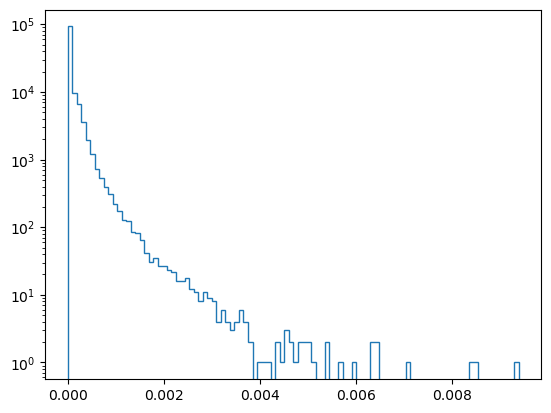

In [15]:
#plot event_weight feature for events with ditau_pt less than 0.4*1e6
e_weigt_cut = new_jz[(new_jz['ditau_pt'] < 0.4*1e6) & (new_jz['weight'] < 10)]
plt.hist(e_weigt_cut['weight'], bins=100, histtype='step', label='ditau_pt < 0.4*1e6')
plt.yscale('log')
plt.show()

2.60900393083828e-13
0.3355826179618836
1.1831948123342003e-09
0.2431286679500598


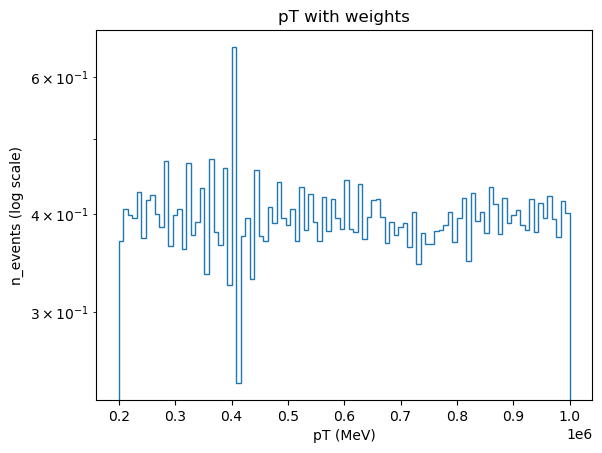

In [23]:
# combined_bkg_n = combined_bkg
#filter events with event_weight biogger than 4*1e6
# combined_bkg_n = combined_bkg_n[combined_bkg_n.f_core_subl != -999]

# combined_bkg_n = combined_bkg_n[combined_bkg_n['event_weight'] < 100]

print(np.min(new_jz['weight']))
print(np.max(new_jz['weight']))
print(np.min(new_vh['weight']))
print(np.max(new_vh['weight']))

plt.hist(new_jz['ditau_pt'], bins=100,  weights=new_jz['weight'], histtype='step')
plt.yscale('log')
plt.xlabel('pT (MeV)')
plt.ylabel('n_events (log scale)')
plt.title('pT with weights')
plt.show()


In [20]:
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/"
combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
combined_signal = pd.read_csv(path+'inc_bdt_signal.csv')

In [3]:
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"
combined_bkg = pd.read_csv(path+'combined_jz_ntuple_inc_omni.csv')
combined_signal = pd.read_csv(path+'vhtautau_ntuple_inc_omni.csv')

In [15]:
signal_scores = combined_signal['bdt_score']
print(np.sum(signal_scores > 0.72) / len(signal_scores))

bkg = combined_bkg['bdt_score']
print(np.sum(bkg > 0.55) / len(bkg))

0.7399353808782297


In [51]:
bkg_bdt = combined_bkg['bdt_score_new'][combined_bkg['bdt_score_new'] > 0]
# print(np.sum(bkg_bdt > 0.045) / len(bkg_bdt))
print(np.sum(bkg_bdt > 0.045) / len(bkg_bdt))

sig_bdt = combined_signal['bdt_score_new'][combined_signal['bdt_score_new'] > 0]
# print(np.sum(sig_bdt > 0.045) / len(sig_bdt))
print(np.sum(sig_bdt > 0.957) / len(sig_bdt))

0.30280855472248075
0.7333744039345224


In [56]:
bkg_omni = combined_bkg['omni_probs'][combined_bkg['omni_probs'] > 0]
# print(np.sum(bkg_omni > 0.015) / len(bkg_omni))
print(np.sum(bkg_omni > 0.013) / len(bkg_omni))

sig_omni = combined_signal['omni_probs'][combined_signal['omni_probs'] > 0]
# print(np.sum(sig_omni > 0.015) / len(sig_omni))
print(np.sum(sig_omni > 0.99951) / len(sig_omni))

0.3105520535196924
0.7365197102768344


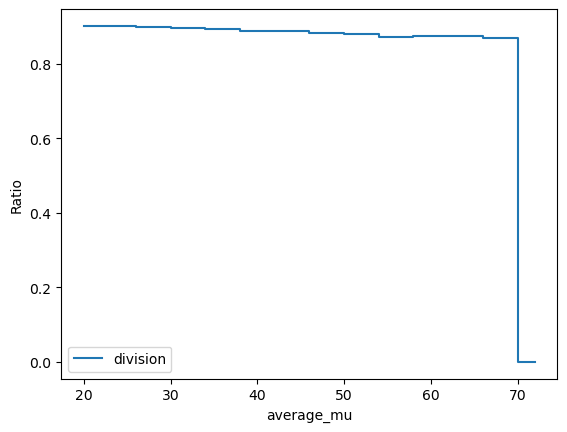

In [30]:

bins = np.linspace(18, 74, 15)
hist1, _ = np.histogram(combined_signal['average_mu'][combined_signal['bdt_score_new'] > 0.8], bins=bins)
hist2, _ = np.histogram(combined_signal['average_mu'][combined_signal['bdt_score_new'] > 0], bins=bins)

# Avoid division by zero by replacing zeros in hist2 with a very small number
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# Calculate the division of the two histograms
hist_division = hist1 / hist2

# Plot the resulting histogram
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.step(bin_centers, hist_division, where='mid', label='division')
plt.xlabel('average_mu')
plt.ylabel('Ratio')
plt.legend()
plt.show()


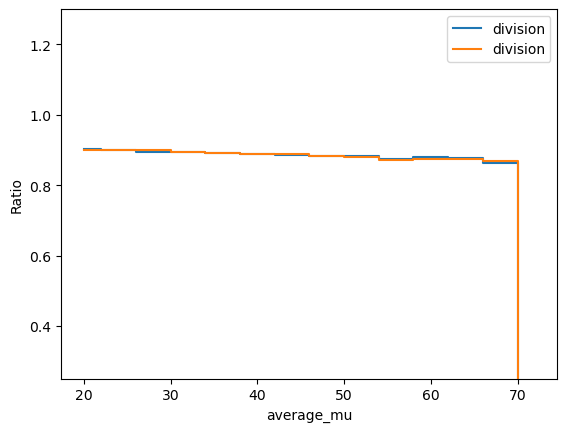

In [31]:

bins = np.linspace(18, 74, 15)
hist3, _ = np.histogram(combined_signal['average_mu'][combined_signal['omni_probs'] > 0.9961], bins=bins)
hist4, _ = np.histogram(combined_signal['average_mu'][combined_signal['omni_probs'] > 0], bins=bins)

# Avoid division by zero by replacing zeros in hist2 with a very small number
hist4 = np.where(hist4 == 0, 1e-10, hist4)

# Calculate the division of the two histograms
hist_division_omni = hist3 / hist4

# Plot the resulting histogram
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.step(bin_centers, hist_division_omni, where='mid', label='division')
plt.step(bin_centers, hist_division, where='mid', label='division')

# plt.step(bin_centers, hist3, where='mid', label='division')
#make teh y axis range from 0.3 to 1.5
plt.ylim(0.25, 1.3)
plt.xlabel('average_mu')
plt.ylabel('Ratio')
plt.legend()
plt.show()


In [33]:
print(hist1)
print(hist3)


[  8889  34988  87662 113606 118301 115475  92634  90647  98013  75002
  16467   4766   3469      0]
[  8891  34945  87352 113414 118260 115370  92598  90777  98346  75264
  16557   4785   3446      0]


In [6]:
len(combined_bkg), len(combined_signal)

(227804, 969063)

In [23]:
import pandas as pd

class DataFrameCuts:
    def __init__(self, df_bkg, df_signal):
        self.df_bkg = df_bkg
        self.df_signal = df_signal

    def apply_cut(self, df, cut_condition):
        return df[cut_condition]

    def cut4(self, df):
        return self.apply_cut(df, ((df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 3)) | ((df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 1)))

    def cut5(self, df):
        return self.apply_cut(df, (df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 1))

    def cut6(self, df):
        return self.apply_cut(df, (df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 3))

    def cut7(self, df):
        return self.apply_cut(df, ((df['n_tracks_lead'] == 1) | (df['n_tracks_lead'] == 3)) & ((df['n_tracks_subl'] == 1) | (df['n_tracks_subl'] == 3)))

    def process(self):
        self.combined_bkg_1p3p = self.cut4(self.df_bkg)
        self.combined_bkg_1p1p = self.cut5(self.df_bkg)
        self.combined_bkg_3p3p = self.cut6(self.df_bkg)

        self.combined_signal_1p3p = self.cut4(self.df_signal)
        self.combined_signal_1p1p = self.cut5(self.df_signal)
        self.combined_signal_3p3p = self.cut6(self.df_signal)


        return {
            'bkg': {
                '1p3p': self.combined_bkg_1p3p,
                '1p1p': self.combined_bkg_1p1p,
                '3p3p': self.combined_bkg_3p3p,
                'inc': self.df_bkg
            },
            'signal': {
                '1p3p': self.combined_signal_1p3p,
                '1p1p': self.combined_signal_1p1p,
                '3p3p': self.combined_signal_3p3p,
                'inc': self.df_signal
            }
        }

In [24]:
combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
combined_signal = pd.read_csv(path+'inc_bdt_vhtautau.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.72]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

# Accessing the results
combined_bkg_1p3p = combined['bkg']['1p3p']
combined_bkg_1p1p = combined['bkg']['1p1p']
combined_bkg_3p3p = combined['bkg']['3p3p']
combined_bkg_inc = combined['bkg']['inc']
combined_signal_1p3p = combined['bkg']['1p3p']
combined_signal_1p1p = combined['bkg']['1p1p']
combined_signal_3p3p = combined['bkg']['3p3p']
combined_signal_inc = combined['bkg']['inc']

combined_bkg_1p3p_bdt = combined_bdt['bkg']['1p3p']
combined_bkg_1p1p_bdt = combined_bdt['bkg']['1p1p']
combined_bkg_3p3p_bdt = combined_bdt['bkg']['3p3p']
combined_bkg_inc_bdt = combined_bdt['bkg']['inc']
combined_signal_1p3p_bdt = combined_bdt['bkg']['1p3p']
combined_signal_1p1p_bdt = combined_bdt['bkg']['1p1p']
combined_signal_3p3p_bdt = combined_bdt['bkg']['3p3p']
combined_signal_inc_bdt = combined_bdt['bkg']['inc']



In [27]:
combined

{'bkg': {'1p3p':          event_id   ditau_pt  IsTruthHadronic  f_core_lead  f_core_subl  \
  0        36079784  289045.94                0     0.894528     0.246616   
  3        35893734  248336.08                0     0.680812     0.653458   
  6        26917460  221883.73                0     0.882286     0.677054   
  9        32924154  208441.89                0     0.842463     0.460940   
  11       30846038  204277.62                0     0.904852     0.615187   
  ...           ...        ...              ...          ...          ...   
  2180550   1082150  252817.34                0     0.726470     0.277918   
  2180555   1284683  253029.23                0     0.669082     0.294558   
  2180557   1489518  298590.72                0     0.768915     0.246262   
  2180559   1110524  325928.28                0     0.757148     0.080900   
  2180561   1033696  290693.70                0     0.959796     0.055276   
  
           f_subjet_subl  f_subjets  f_isotracks  R_max_le

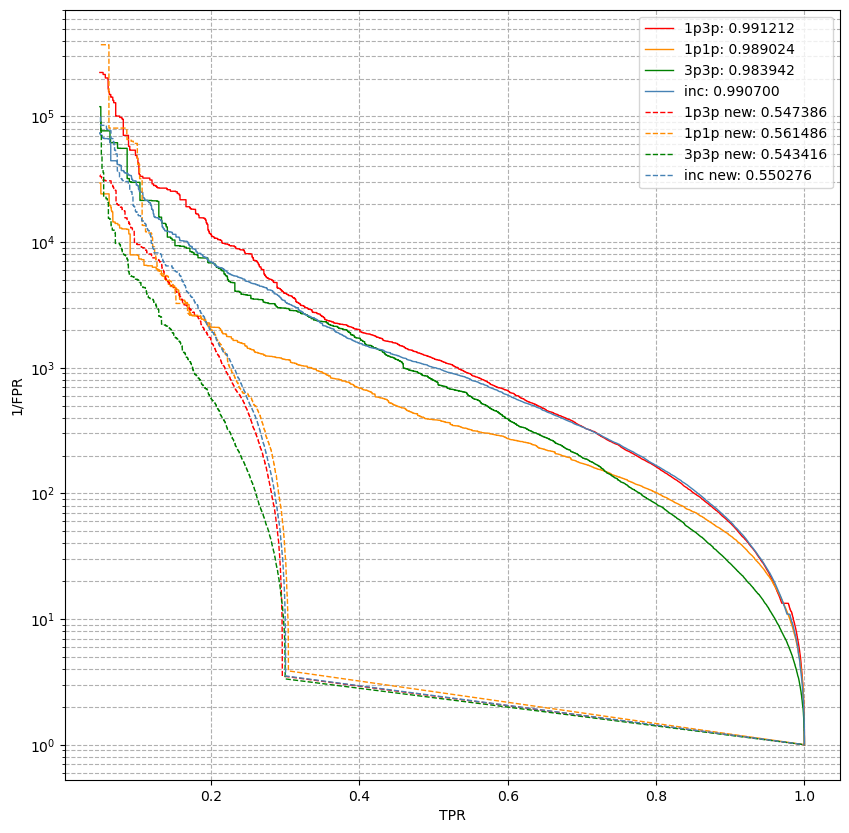

In [26]:
channel = ['1p3p', '1p1p', '3p3p', 'inc']
color = ['red', 'darkorange', 'green', 'steelblue']

fig7 = plt.figure(figsize=(10, 10))
for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score'], combined['bkg'][channel[i]]['bdt_score'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f'{channel[i]}: {roc_auc:.6f}')

for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['inc_new_bdt'], combined['bkg'][channel[i]]['inc_new_bdt'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], linestyle='dashed', label=f'{channel[i]} new: {roc_auc:.6f}')
             
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [8]:
''' Testing for Testing Data
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

def tmp(df):
    df['eventID_mod'] = df['event_id'] % 10
    train_df = df[df['eventID_mod'] < 7] # 70%
    test_df = df[df['eventID_mod'] >= 7] # 30%
    return test_df

combined_signal = tmp(combined_signal)
combined_bkg = tmp(combined_bkg)

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

channel = ['1p3p', '1p1p', '3p3p', 'inc']
color = ['red', 'darkorange', 'green', 'steelblue']

fig7 = plt.figure(figsize=(10, 10))
for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score'], combined['bkg'][channel[i]]['bdt_score'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f'{channel[i]}: {roc_auc:.6f}')

for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score_new'], combined['bkg'][channel[i]]['bdt_score_new'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], linestyle='dashed', label=f'{channel[i]} new: {roc_auc:.6f}')
             
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
'''

' Testing for Testing Data\ncombined_bkg = pd.read_csv(path+\'combined_bkg_inc.csv\')\ncombined_signal = pd.read_csv(path+\'combined_signal_inc.csv\')\n\ndef tmp(df):\n    df[\'eventID_mod\'] = df[\'event_id\'] % 10\n    train_df = df[df[\'eventID_mod\'] < 7] # 70%\n    test_df = df[df[\'eventID_mod\'] >= 7] # 30%\n    return test_df\n\ncombined_signal = tmp(combined_signal)\ncombined_bkg = tmp(combined_bkg)\n\ncuts_processor = DataFrameCuts(combined_bkg, combined_signal)\ncombined = cuts_processor.process()\n\nchannel = [\'1p3p\', \'1p1p\', \'3p3p\', \'inc\']\ncolor = [\'red\', \'darkorange\', \'green\', \'steelblue\']\n\nfig7 = plt.figure(figsize=(10, 10))\nfor i in range(4):\n    fpr, tpr = calc_roc(combined[\'signal\'][channel[i]][\'bdt_score\'], combined[\'bkg\'][channel[i]][\'bdt_score\'], combined[\'signal\'][channel[i]][\'weight\'], combined[\'bkg\'][channel[i]][\'weight\'])\n    roc_auc = auc(fpr, tpr)\n    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f\'{channel[i]

In [49]:
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.96]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

%jsroot on
ROOT.gStyle.SetOptStat(0)
ROOT.gROOT.SetBatch(True)
canvas = ROOT.TCanvas("canvas", "eff_plots", 800, 500)
# canvas.cd()
# canvas.Print("eff_plots.pdf[")

class DataList:
    def __init__(self, combined, combined_bdt):
        self.combined = combined
        self.combined_bdt = combined_bdt
        self.categories = ['1p3p', '1p1p', '3p3p', 'inc']

    def create_list(self, sig_bkg, variable):
        data_list = []
        for category in self.categories:
            data_list.append(self.combined[sig_bkg][category][variable])
            data_list.append(self.combined_bdt[sig_bkg][category][variable])
        return data_list
    
data_list = DataList(combined, combined_bdt)

sig_pt_list = data_list.create_list('signal', 'ditau_pt')
sig_eta_list = data_list.create_list('signal', 'eta')
sig_mu_list = data_list.create_list('signal', 'average_mu')
sig_w_list = data_list.create_list('signal', 'event_weight')
bkg_pt_list = data_list.create_list('bkg', 'ditau_pt')
bkg_eta_list = data_list.create_list('bkg', 'eta')
bkg_mu_list = data_list.create_list('bkg', 'average_mu')
bkg_w_list = data_list.create_list('bkg', 'event_weight')

pt_1p3p_eff_w, pt_1p1p_eff_w, pt_3p3p_eff_w, pt_inc_eff_w = plot_eff(bkg_pt_list, bkg_w_list, "DiJet pT", 20, 200000, 1000000, eta=False)
pt_1p3p_eff_w.SetMarkerStyle(22)
pt_1p1p_eff_w.SetMarkerStyle(22)
pt_3p3p_eff_w.SetMarkerStyle(22)
pt_inc_eff_w.SetMarkerStyle(22)
pt_1p3p_eff_w.Draw(" e")
pt_1p1p_eff_w.Draw("same e")
pt_3p3p_eff_w.Draw("same e")
pt_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(pt_1p3p_eff_w, "1p3p w")
legend.AddEntry(pt_1p1p_eff_w, "1p1p w")
legend.AddEntry(pt_3p3p_eff_w, "3p3p w")
legend.AddEntry(pt_inc_eff_w, "inclusive w")
legend.Draw()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [50]:
eta_1p3p_eff_w, eta_1p1p_eff_w, eta_3p3p_eff_w, eta_inc_eff_w = plot_eff(bkg_eta_list, bkg_w_list, "DiJet eta", 40, -2.5, 2.5, eta=True)
eta_1p3p_eff_w.SetMarkerStyle(22)
eta_1p1p_eff_w.SetMarkerStyle(22)
eta_3p3p_eff_w.SetMarkerStyle(22)
eta_inc_eff_w.SetMarkerStyle(22)
eta_1p3p_eff_w.Draw(" e")
eta_1p1p_eff_w.Draw("same e")
eta_3p3p_eff_w.Draw("same e")
eta_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(eta_1p3p_eff_w, "1p3p")
legend.AddEntry(eta_1p1p_eff_w, "1p1p")
legend.AddEntry(eta_3p3p_eff_w, "3p3p")
legend.AddEntry(eta_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [51]:
eta_inc_eff_w.SetMarkerStyle(22)
eta_inc_eff_w.SetLineColor(ROOT.kBlue)
eta_inc_eff_w.Draw(" e")
legend = ROOT.TLegend(0.7, 0.8, 0.85, 0.9)
legend.AddEntry(eta_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

In [52]:
mu_1p3p_eff_w, mu_1p1p_eff_w, mu_3p3p_eff_w, mu_inc_eff_w = plot_eff(bkg_mu_list, bkg_w_list, "DiJet mu", 20, 18, 74, eta=False)
mu_1p3p_eff_w.SetMarkerStyle(22)
mu_1p1p_eff_w.SetMarkerStyle(22)
mu_3p3p_eff_w.SetMarkerStyle(22)
mu_inc_eff_w.SetMarkerStyle(22)
mu_1p3p_eff_w.Draw(" e")
mu_1p1p_eff_w.Draw("same e")
mu_3p3p_eff_w.Draw("same e")
mu_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(mu_1p3p_eff_w, "1p3p")
legend.AddEntry(mu_1p1p_eff_w, "1p1p")
legend.AddEntry(mu_3p3p_eff_w, "3p3p")
legend.AddEntry(mu_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [53]:
mu_inc_eff_w.SetMarkerStyle(22)
mu_inc_eff_w.SetLineColor(ROOT.kBlue)
mu_inc_eff_w.Draw(" e")
legend = ROOT.TLegend(0.7, 0.7, 0.85, 0.85)
legend.AddEntry(mu_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()


In [54]:
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.96]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

class DataList:
    def __init__(self, combined, combined_bdt):
        self.combined = combined
        self.combined_bdt = combined_bdt
        self.categories = ['1p3p', '1p1p', '3p3p', 'inc']

    def create_list(self, sig_bkg, variable):
        data_list = []
        for category in self.categories:
            data_list.append(self.combined[sig_bkg][category][variable])
            data_list.append(self.combined_bdt[sig_bkg][category][variable])
        return data_list
    
data_list = DataList(combined, combined_bdt)

sig_pt_list = data_list.create_list('signal', 'ditau_pt')
sig_eta_list = data_list.create_list('signal', 'eta')
sig_mu_list = data_list.create_list('signal', 'average_mu')
sig_w_list = data_list.create_list('signal', 'event_weight')
bkg_pt_list = data_list.create_list('bkg', 'ditau_pt')
bkg_eta_list = data_list.create_list('bkg', 'eta')
bkg_mu_list = data_list.create_list('bkg', 'average_mu')
bkg_w_list = data_list.create_list('bkg', 'event_weight')

In [55]:
pt_sig_1p3p_eff_w, pt_sig_1p1p_eff_w, pt_sig_3p3p_eff_w, pt_sig_inc_eff_w = plot_eff(sig_pt_list, sig_w_list, "Signal pT", 20, 200000, 1000000, eta=False)
pt_sig_1p3p_eff_w.SetMarkerStyle(22)
pt_sig_1p1p_eff_w.SetMarkerStyle(22)
pt_sig_3p3p_eff_w.SetMarkerStyle(22)
pt_sig_inc_eff_w.SetMarkerStyle(22)
pt_sig_1p3p_eff_w.Draw(" e")
pt_sig_1p1p_eff_w.Draw("same e")
pt_sig_3p3p_eff_w.Draw("same e")
pt_sig_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(pt_sig_1p3p_eff_w, "1p3p w")
legend.AddEntry(pt_sig_1p1p_eff_w, "1p1p w")
legend.AddEntry(pt_sig_3p3p_eff_w, "3p3p w")
legend.AddEntry(pt_sig_inc_eff_w, "inclusive w")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [7]:
#load h5 file 
# path = "/global/homes/a/agarabag/pscratch/OmniLearn/qg/QG/"
# filename = "train_qg.h5"

path =  '/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/'
filename = 'train_tau.h5'
hf = h5py.File
hf = h5py.File(path+filename, 'r')
hf.keys()

#look at the keys
for key in hf.keys():
    print(key)

#printes keys are data, jet, pid
#print content of data key
print(hf['data'])
print(hf['jet'])
print(hf['pid'])
print(hf['weights'])



data
jet
pid
weights
<HDF5 dataset "data": shape (4343244, 10, 11), type "<f8">
<HDF5 dataset "jet": shape (4343244, 16), type "<f8">
<HDF5 dataset "pid": shape (4343244,), type "<i8">
<HDF5 dataset "weights": shape (4343244,), type "<f8">


In [8]:
print(hf['weights'][:])
print(np.min(hf['weights']), np.max(hf['weights']))

[4.15817115e-11 3.79176693e-10 5.41947164e-10 ... 9.27698310e-11
 3.29180697e-11 1.46691256e-11]
0.0 76513322322.04338


In [11]:
# Assuming hf['weights'][:] contains the weights
weights = hf['weights'][:]

# Define epsilon to avoid log(0)
epsilon = 1e-8

# Compute log weights
log_weights = np.log(weights + epsilon)

# Find the minimum log weight
min_log_weight = np.min(log_weights)

# Scale the weights
scaled_weights = np.exp(log_weights - min_log_weight)

print(scaled_weights)
#print scale weights
print(np.min(scaled_weights), np.max(scaled_weights))

[1.00415817 1.03791767 1.05419472 ... 1.00927698 1.00329181 1.00146691]
1.0 7.651332232204386e+18


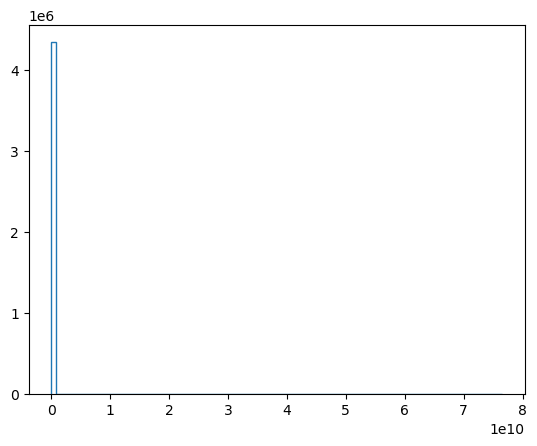

In [9]:
plt.hist(hf['weights'][:], bins=100, histtype='step')
plt.show()

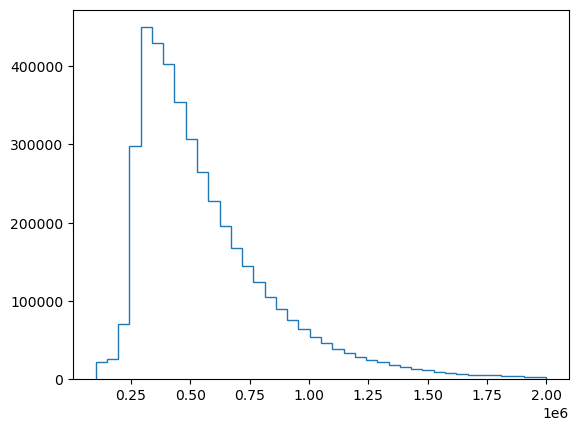

In [10]:
#ket forst variable fo jet
pt = hf['jet'][:, 0]
# pt_bins = np.linspace(200000, 1000000, 41)
# pt_flattening_weights = flattened_pt(pt, pt_bins)
# w = hf['weights'][:]
# plot pt with weoghts w 
binz = np.linspace(100000, 2000000, 41)
plt.hist(pt, bins=binz, histtype='step', )
plt.show()


In [14]:
print(hf['data'][0])


[[ 3.86930109e-01 -8.97137871e-03 -5.36898737e-04 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.25582595e-01 -2.00129615e-01 -3.19737129e-04 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.24110776e-02 -2.46504954e-01 -2.29666070e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [8]:
#load h5 file 
#path = "/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/"
path = "/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/"
filename = "train_tau.h5"

path_top = "/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/data_only_pt_w/"
filename_top = "train_tau.h5"

hf = h5py.File(path+filename, 'r')
print(hf.keys())
print(hf['data'])
print(hf['jet'])
print(hf['pid'])
print(hf['weights'])
#chekc if all data values are finite
print(np.all(np.isfinite(hf['data'])))
print(np.all(np.isfinite(hf['jet'])))


hf_top = h5py.File(path_top+filename_top, 'r')
print(hf_top.keys())
print(hf_top['data'])
print(hf_top['jet'])
print(hf_top['pid'])
print(hf_top['weights'])
print(np.all(np.isfinite(hf_top['data'])))
print(np.all(np.isfinite(hf_top['jet'])))

# filename2 = "test_tau.h5"
# hf2 = h5py.File
# hf2 = h5py.File(path+filename2, 'r')
# print(hf2['data'])
# print(hf2['jet'])
# print(hf2['pid'])
# hf2.keys()

# filename2 = "val_tau.h5"
# hf3 = h5py.File
# hf3 = h5py.File(path+filename2, 'r')
# print(hf3['data'])
# print(hf3['jet'])
# print(hf3['pid'])
# hf3.keys()

<KeysViewHDF5 ['data', 'jet', 'pid', 'weights']>
<HDF5 dataset "data": shape (3767929, 10, 11), type "<f8">
<HDF5 dataset "jet": shape (3767929, 16), type "<f8">
<HDF5 dataset "pid": shape (3767929,), type "<i8">
<HDF5 dataset "weights": shape (3767929,), type "<f8">
True
True
<KeysViewHDF5 ['data', 'jet', 'pid', 'weights']>
<HDF5 dataset "data": shape (4343244, 10, 11), type "<f8">
<HDF5 dataset "jet": shape (4343244, 16), type "<f8">
<HDF5 dataset "pid": shape (4343244,), type "<i8">
<HDF5 dataset "weights": shape (4343244,), type "<f8">
True
True


In [9]:
print(hf['weights'][:5])
print(hf_top['weights'][:5])
print(np.max(hf['weights']), np.min(hf['weights']))
print(np.max(hf_top['weights']), np.min(hf_top['weights']))

#print how many pid of 0 and 1 are there
print(np.sum(hf_top['pid'][:] == 0))
print(np.sum(hf_top['pid'][:] == 1))

[2.98770771e-02 5.86782053e-10 6.15072910e-09 1.36938387e-09
 1.72439575e-11]
[4.80240504e-06 4.14203879e-06 0.00000000e+00 0.00000000e+00
 3.99726587e-06]
76513232484.2067 0.0
1.0 0.0
959662
3383582


In [8]:
print(len(hf['weights'][:]))
print(hf['weights'][:20])
# print(len(hf2['pid'][:]))
# print(hf2['pid'][:])
# print(len(hf3['pid'][:]))
# print(hf3['pid'][:])

#see if there are any negative values in the weights
print(np.any(hf['weights'][:] == 0))

#print max a dn min values of weights
print(np.max(hf['weights'][:]))
print(np.min(hf['weights'][:]))


#subtract the min value from the weights
weights_m = hf['weights'][:]
weights_m = weights_m - np.min(weights_m) + 1e-6
print(np.any(weights_m == 0))
#normalize the weights
weights_m = weights_m / np.sum(weights_m)
print(weights_m[:20])
print(np.max(weights_m))
print(np.min(weights_m))


3383582
[4.11799162e-10 6.37130812e-11 3.68563404e-12 1.36049208e-10
 6.97374843e-10 1.62439653e-10 1.99863118e-09 5.01100193e-10
 1.69281379e-09 1.89551161e-10 2.28004645e-11 2.00680684e-11
 3.53093958e-10 2.44069591e-11 6.31373551e-09 2.84354297e-10
 2.65687077e-09 7.93367663e-10 1.63497965e-10 4.79962374e-11]
False
0.00021006599428574174
8.040563483951893e-16
False
[2.95171334e-07 2.95068631e-07 2.95050920e-07 2.95089974e-07
 2.95255593e-07 2.95097761e-07 2.95639529e-07 2.95197682e-07
 2.95549297e-07 2.95105760e-07 2.95056560e-07 2.95055754e-07
 2.95154013e-07 2.95057034e-07 2.96912699e-07 2.95133731e-07
 2.95833742e-07 2.95283916e-07 2.95098073e-07 2.95063994e-07]
6.227498637014591e-05
2.95049833020828e-07


In [3]:
#delta eta
# print(hf['data'][1, :, 0]) 
# print(hf['data'][1, :, 11])
print(np.max(hf['data'][:, :, 0].flatten()) )
print(np.min(hf['data'][:, :, 0].flatten()) )
print(np.max(hf['data'][:, :, 11].flatten()) )
print(np.min(hf['data'][:, :, 11].flatten()) )

#delta phi
# print(hf['data'][6, :, 1])
# print(hf['data'][6, :, 12])
print("phi")
print(np.max(hf['data'][:, :, 1]) )
print(np.min(hf['data'][:, :, 1]) )
print(np.max(hf['data'][:, :, 12]) )
print(np.min(hf['data'][:, :, 12]) )

#log(pt)
# print(hf['data'][6, :, 2])
# print(hf['data'][6, :, 13])
print("pt")
print(np.max(hf['data'][:, :, 2]) )
print(np.min(hf['data'][:, :, 2]) )
print(np.max(hf['data'][:, :, 13]) )
print(np.min(hf['data'][:, :, 13]) )

#pt_log_ratio
# print(hf['data'][6, :, 4])
# print(hf['data'][6, :, 14])
print("pt_log_ratio")
print(np.max(hf['data'][:, :, 4]) )
print(np.min(hf['data'][:, :, 4]) )
print(np.max(hf['data'][:, :, 14]) )
print(np.min(hf['data'][:, :, 14]) )


#deltaR
# print(hf['data'][6, :, 6])
# print(hf['data'][6, :, 15])
print("deltaR")
print(np.max(hf['data'][:, :, 6]) )
print(np.min(hf['data'][:, :, 6]) )
print(np.max(hf['data'][:, :, 15]) )
print(np.min(hf['data'][:, :, 15]) )


0.9971010778099298
-0.9956718683242798
0.9971010684967041
-0.9956718683242798
phi
0.9983595609664917
-0.9945704638957977
0.9983595609664917
-0.9945704936981201
pt
20.539323075510094
0.0
20.539323806762695
0.0
pt_log_ratio
0.0
-8.041189375003816
nan
nan
deltaR
0.9999980018603414
0.0
0.9999979734420776
0.0


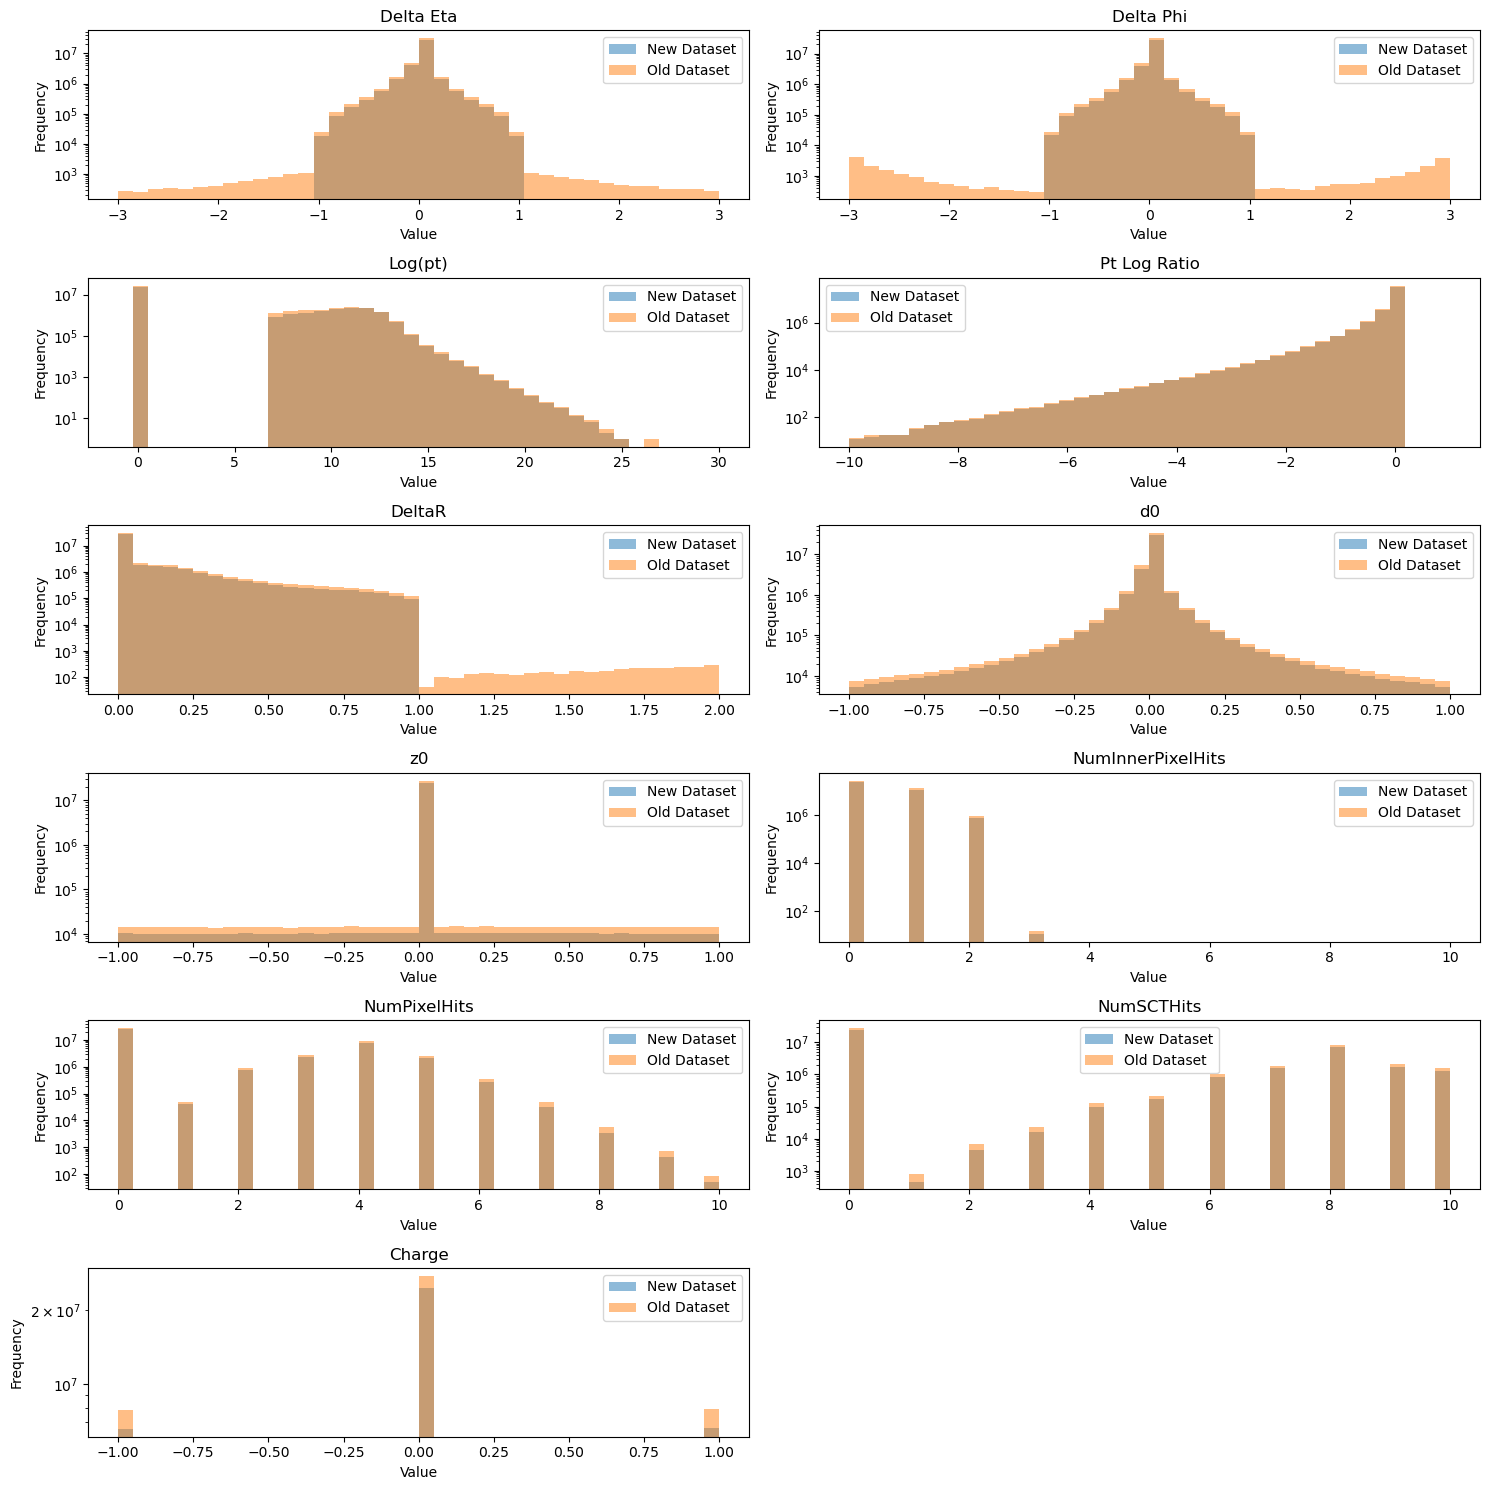

In [4]:
# Extract the data
delta_eta_1 = hf['data'][:, :, 0].flatten()
# delta_eta_2 = hf['data'][:, :, 11].flatten()
delta_eta_2 = hf_top['data'][:, :, 0].flatten()

delta_phi_1 = hf['data'][:, :, 1].flatten()
# delta_phi_2 = hf['data'][:, :, 12].flatten()
delta_phi_2 = hf_top['data'][:, :, 1].flatten()

log_pt_1 = hf['data'][:, :, 2].flatten()
# log_pt_2 = hf['data'][:, :, 13].flatten()
log_pt_2 = hf_top['data'][:, :, 2].flatten()

d0_1 = hf['data'][:, :, 3].flatten()
d0_2 = hf_top['data'][:, :, 3].flatten()

pt_log_ratio_1 = hf['data'][:, :, 4].flatten()
# pt_log_ratio_2 = hf['data'][:, :, 14].flatten()
pt_log_ratio_2 = hf_top['data'][:, :, 4].flatten()

z0_1 = hf['data'][:, :, 5].flatten()
z0_2 = hf_top['data'][:, :, 5].flatten()

deltaR_1 = hf['data'][:, :, 6].flatten()
# deltaR_2 = hf['data'][:, :, 15].flatten()
deltaR_2 = hf_top['data'][:, :, 6].flatten()

NumInnerPixelHits_1 = hf['data'][:, :, 7].flatten()
NumInnerPixelHits_2 = hf_top['data'][:, :, 7].flatten()

NumPixelHits_1 = hf['data'][:, :, 8].flatten()
NumPixelHits_2 = hf_top['data'][:, :, 8].flatten()

NumSCTHits_1 = hf['data'][:, :, 9].flatten()
NumSCTHits_2 = hf_top['data'][:, :, 9].flatten()

charge_1 = hf['data'][:, :, 10].flatten()
charge_2 = hf_top['data'][:, :, 10].flatten()

label_1 = "New Dataset"
label_2 = "Old Dataset"

# Plot histograms
plt.figure(figsize=(15, 15))
num_bins = 40
plt.subplot(6, 2, 1)
plt.hist(delta_eta_1, bins=num_bins, alpha=0.5, label=label_1, range=(-3, 3))
plt.hist(delta_eta_2, bins=num_bins, alpha=0.5, label=label_2, range=(-3, 3))
#log y axis
plt.yscale('log')
plt.legend()
plt.title('Delta Eta')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 2)
plt.hist(delta_phi_1, bins=num_bins, alpha=0.5, label=label_1, range=(-3, 3))
plt.hist(delta_phi_2, bins=num_bins, alpha=0.5, label=label_2, range=(-3, 3))
plt.yscale('log')
plt.legend()
plt.title('Delta Phi')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 3)
plt.hist(log_pt_1, bins=num_bins, alpha=0.5, label=label_1, range=(-1, 30))
plt.hist(log_pt_2, bins=num_bins, alpha=0.5, label=label_2, range=(-1, 30))
plt.yscale('log')
plt.legend()
plt.title('Log(pt)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 4)
plt.hist(pt_log_ratio_1, bins=num_bins, alpha=0.5, label=label_1, range=(-10, 1))
plt.hist(pt_log_ratio_2, bins=num_bins, alpha=0.5, label=label_2, range=(-10, 1))
plt.yscale('log')
plt.legend()
plt.title('Pt Log Ratio')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 5)
plt.hist(deltaR_1, bins=num_bins, alpha=0.5, label=label_1, range=(0, 2))
plt.hist(deltaR_2, bins=num_bins, alpha=0.5, label=label_2, range=(0, 2))
plt.yscale('log')
plt.legend()
plt.title('DeltaR')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 6)
plt.hist(d0_1, bins=num_bins, alpha=0.5, label=label_1, range=(-1, 1))
plt.hist(d0_2, bins=num_bins, alpha=0.5, label=label_2, range=(-1, 1))
plt.yscale('log')
plt.legend()
plt.title('d0')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 7)
plt.hist(z0_1, bins=num_bins, alpha=0.5, label=label_1, range=(-1, 1))
plt.hist(z0_2, bins=num_bins, alpha=0.5, label=label_2, range=(-1, 1))
plt.yscale('log')
plt.legend()
plt.title('z0')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 8)
plt.hist(NumInnerPixelHits_1, bins=num_bins, alpha=0.5, label=label_1, range=(0, 10))
plt.hist(NumInnerPixelHits_2, bins=num_bins, alpha=0.5, label=label_2, range=(0, 10))
plt.yscale('log')
plt.legend()
plt.title('NumInnerPixelHits')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 9)
plt.hist(NumPixelHits_1, bins=num_bins, alpha=0.5, label=label_1, range=(0, 10))   
plt.hist(NumPixelHits_2, bins=num_bins, alpha=0.5, label=label_2, range=(0, 10))
plt.yscale('log')
plt.legend()
plt.title('NumPixelHits')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 10)
plt.hist(NumSCTHits_1, bins=num_bins, alpha=0.5, label=label_1, range=(0, 10))
plt.hist(NumSCTHits_2, bins=num_bins, alpha=0.5, label=label_2, range=(0, 10))
plt.yscale('log')
plt.legend()
plt.title('NumSCTHits')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(6, 2, 11)
plt.hist(charge_1, bins=num_bins, alpha=0.5, label=label_1, range=(-1, 1))
plt.hist(charge_2, bins=num_bins, alpha=0.5, label=label_2, range=(-1, 1))
plt.yscale('log')
plt.legend()
plt.title('Charge')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()


In [2]:
#load npy file
path = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/"
filename = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights_new_fixed.npy"
# data = np.load(path+filename, allow_pickle=True)
data = np.load(path+filename,allow_pickle=True).item()

print(data.keys())
#print content of data keys
print(data['pred'].shape)

dict_keys(['y', 'pred', 'event_id', 'weight'])
(1254094, 2)


In [15]:
# the first elemt in the jet array is omni_score
# we want to make a roc curve for the omni_score using pid as the truth
omni_scores = hf['jet'][:, 16]
omni_true = hf['pid'][:]
print("omni score uncut len: ", len(omni_scores))

# Extract event IDs from the jet data
event_ids = hf['jet'][:, 0]
print("len of event_ids: ", len(event_ids))

# # Get the event IDs from the provided data
selected_event_ids = data['event_id'].flatten()
# print("len of selected_event_ids: ", len(selected_event_ids))
selected_indices = np.isin(event_ids, selected_event_ids)

omni_scores_cut = omni_scores[selected_indices]
omni_true_cut = omni_true[selected_indices]
event_ids_cut = event_ids[selected_indices]
# omni_scores_cut = omni_scores
# omni_true_cut = omni_true
# event_ids_cut = event_ids

omni_scores_cut = np.array(omni_scores_cut, dtype=np.float32)

print("omni score cut len: ", len(omni_scores_cut))
print(omni_scores_cut.shape, omni_true_cut.shape)
#pritn how many omni_true are 0 and 1
print(np.sum(omni_true_cut == 0))
print(np.sum(omni_true_cut == 1))

# omni_fpr, omni_tpr, _ = roc_curve(omni_true_cut, omni_scores_cut)
# omni_fpr = omni_fpr[omni_tpr > 0.05]
# omni_tpr = omni_tpr[omni_tpr > 0.05]
# omni_auc = roc_auc_score(omni_true_cut, omni_scores_cut)


IndexError: Index (16) out of range for (0-15)

In [3]:
filename_n = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
# data = np.load(path+filename, allow_pickle=True)
data_n = np.load(path+filename_n,allow_pickle=True).item()

In [4]:
y_scores = data['pred'][:, 1]  # Select the predicted probabilities for the positive class
y_true = np.argmax(data['y'], axis=1)
#selected onyl scores that match the event_ids 
# y_scores = y_scores[np.isin(selected_event_ids, event_ids)]
# y_true = y_true[np.isin(selected_event_ids, event_ids)]
print(np.sum(y_true == 0))
print(np.sum(y_true == 1))
fpr_w, tpr_w, thresholds_w = roc_curve(y_true, y_scores)
fpr_w = fpr_w[tpr_w > 0.01]
tpr_w = tpr_w[tpr_w > 0.01]
auc_w = roc_auc_score(y_true, y_scores)

y_scores_n = data_n['pred'][:, 1]
y_true_n = np.argmax(data_n['y'], axis=1)  
print(np.sum(y_true_n == 0))
print(np.sum(y_true_n == 1))
# y_true_n = data_n['y'] 
# y_scores_n = data_n['pred']
# weight_n = data_n['weight']
fpr_n, tpr_n, thresholds_n = roc_curve(y_true_n, y_scores_n)
fpr_n = fpr_n[tpr_n > 0.01]
tpr_n = tpr_n[tpr_n > 0.01]
auc_n = roc_auc_score(y_true_n, y_scores_n)

158612
1095482
158612
1095482


Last bin contents:
Old model:  [   2733    1386     855     738     706     797     868     972    1220
    1646    2411    3635    7476 1070039]
New model:  [   4041    1197    1114    1104    1219    1359    1518    1817    2171
    2896    3930    5906   12038 1055172]


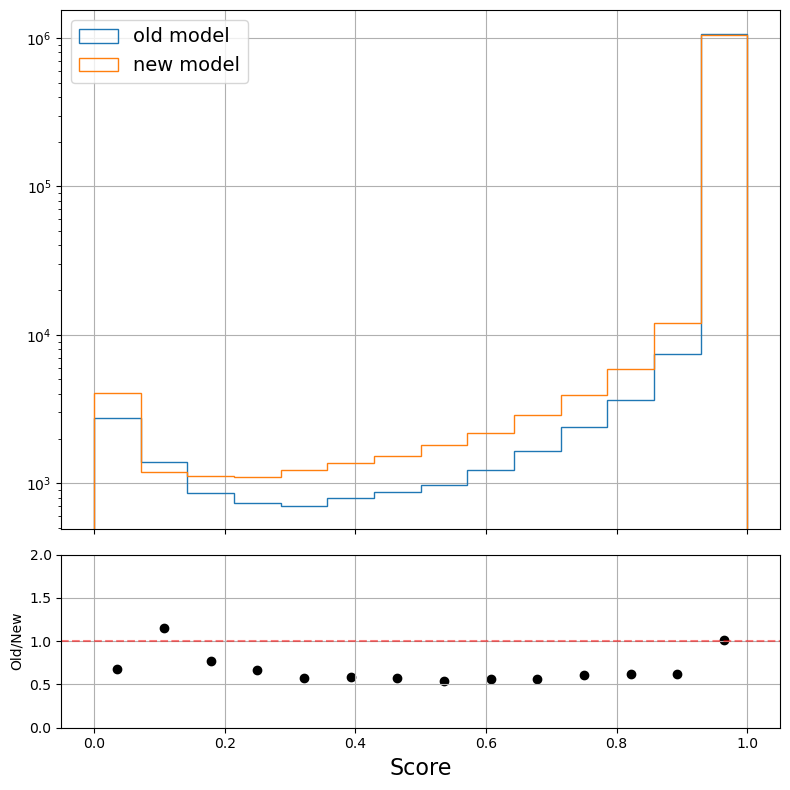

In [10]:
# Create figure with 2 subplots, sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), height_ratios=[3, 1], sharex=True)

# Top panel - histograms
bins = np.linspace(0, 1, 15)
h1, _ = np.histogram(y_scores[y_true==1], bins=bins)
h2, _ = np.histogram(y_scores_n[y_true_n==1], bins=bins)

print("Last bin contents:")
print(f"Old model: ", h1)
print(f"New model: ", h2)

# Convert to float64
h1 = h1.astype(np.float64)
h2 = h2.astype(np.float64)

ax1.hist(y_scores[y_true==1], bins=bins, label='old model', histtype='step')
ax1.hist(y_scores_n[y_true_n==1], bins=bins, label='new model', histtype='step')
ax1.set_yscale('log')
ax1.legend(prop={'size': 14})
ax1.grid(True)

# Bottom panel - ratio
bin_centers = (bins[:-1] + bins[1:]) / 2
ratio = np.divide(h1, h2, out=np.zeros_like(h1, dtype=np.float64), where=h2!=0)
ax2.scatter(bin_centers, ratio, color='black')
ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Old/New')
ax2.set_xlabel('Score', fontsize=16)
ax2.grid(True)
ax2.set_ylim(0, 2)

plt.tight_layout()

/tmp/ipykernel_1775957/1495754341.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_w, 1/fpr_w, lw=1, label='Old Model')
/tmp/ipykernel_1775957/1495754341.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_n, 1/fpr_n, lw=1, label='New Model')


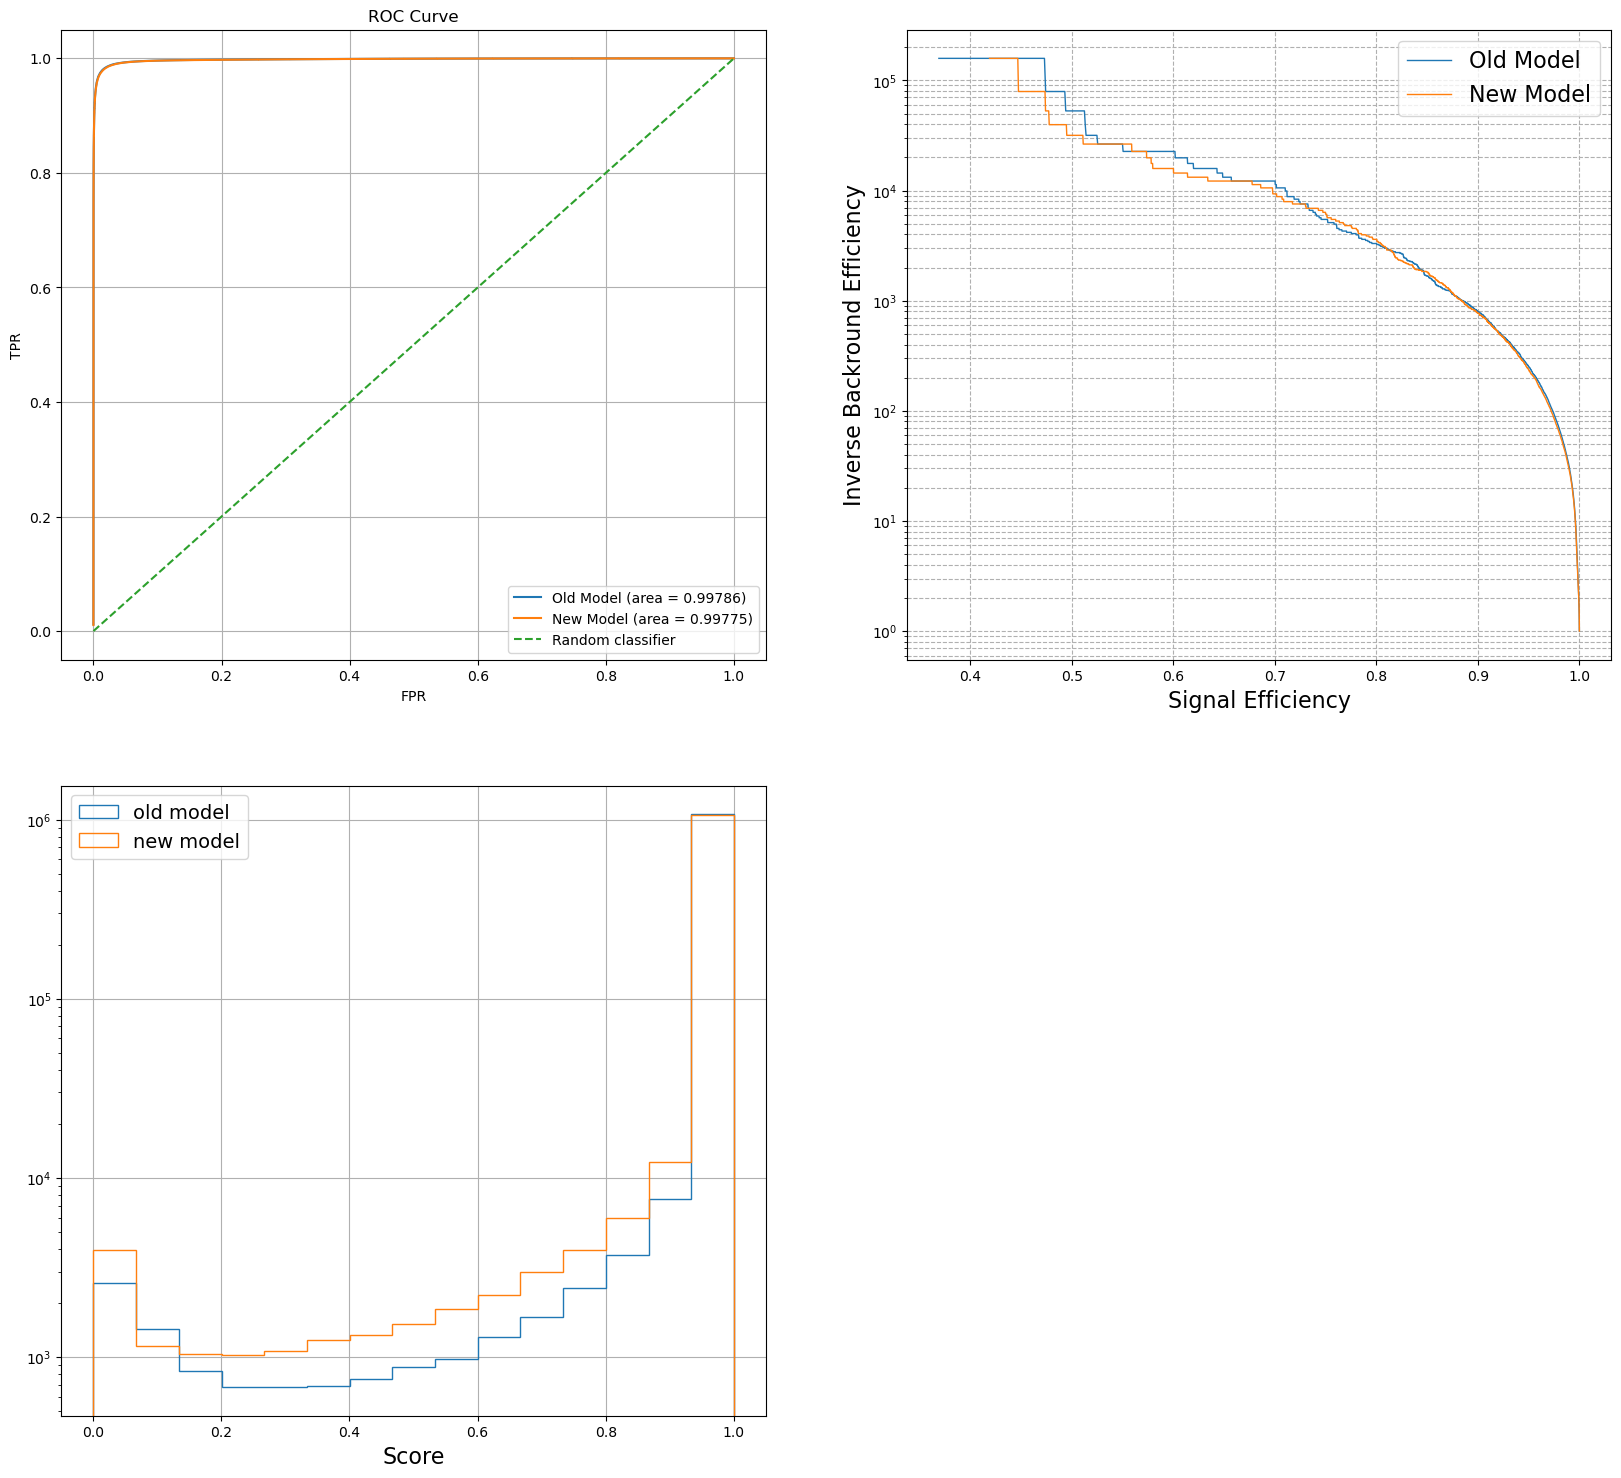

In [9]:
plt.figure(figsize=(20, 18))
plt.subplot(221)
plt.plot(fpr_w, tpr_w, label='Old Model (area = {:.5f})'.format(auc_w))
plt.plot(fpr_n, tpr_n, label='New Model (area = {:.5f})'.format(auc_n))
# plt.plot(omni_fpr, omni_tpr, label='Omni(area = {:.5f})'.format(auc_n))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(tpr_w, 1/fpr_w, lw=1, label='Old Model')
plt.plot(tpr_n, 1/fpr_n, lw=1, label='New Model')
# plt.plot(omni_tpr, 1/omni_fpr, lw=1, label='Omni')
plt.xlabel('Signal Efficiency', fontsize=16)
plt.ylabel('Inverse Backround Efficiency', fontsize=16)
plt.yscale('log')
plt.legend(prop={'size': 16})
plt.grid(True, which="both", ls="--")

plt.subplot(223)
plt.hist(y_scores[y_true==1], bins=15, label='old model', histtype='step')
plt.hist(y_scores_n[y_true_n==1], bins=15, label='new model', histtype='step')
plt.xlabel('Score', fontsize=16)
plt.yscale('log')
plt.legend(prop={'size': 14})
plt.grid(True)


# #make ratio plot between tensorflow and onnx
# plt.subplot(224)
# bins = np.linspace(0, 1, 15)
# hist1, _ = np.histogram(y_scores[y_true==1], bins=bins)
# # # hist2, _ = np.histogram(y_scores[y_true==0], bins=bins)
# # # hist3, _ = np.histogram(omni_scores_cut[omni_true_cut==1], bins=bins)
# # # hist4, _ = np.histogram(omni_scores_cut[omni_true_cut==0], bins=bins)
# hist3, _ = np.histogram(omni_scores_cut, bins=bins)


# # # Calculate the division of the two histograms
# # hist_division = hist1 / hist3
# # # hist_division_omni = hist2 / hist4
# hist_subtraction = hist1 - hist3

# # # Plot the resulting histogram
# bin_centers = (bins[:-1] + bins[1:]) / 2
# plt.step(bin_centers, hist_subtraction, where='mid', label='Signal')
# # plt.step(bin_centers, hist_division_omni, where='mid', label='Background')
# plt.xlabel('Score', fontsize=16)
# plt.ylabel('Score (tensorflow - onnx)', fontsize=16)
# plt.legend(prop={'size': 14})
# plt.grid(True)


plt.show()

Shape of prediction events: (1254094, 1)
Shape of training events: (1254094,)
Number of matched events: 1254094

Data features shape: (1254094, 10, 11)
Jet features shape: (1254094, 16)

Plotting data features...

Plotting jet features...

Summary Statistics:
Total background events: 158612
High-scoring events (>0.8): 3659 (2.31%)
Low-scoring events (≤0.8): 154953 (97.69%)


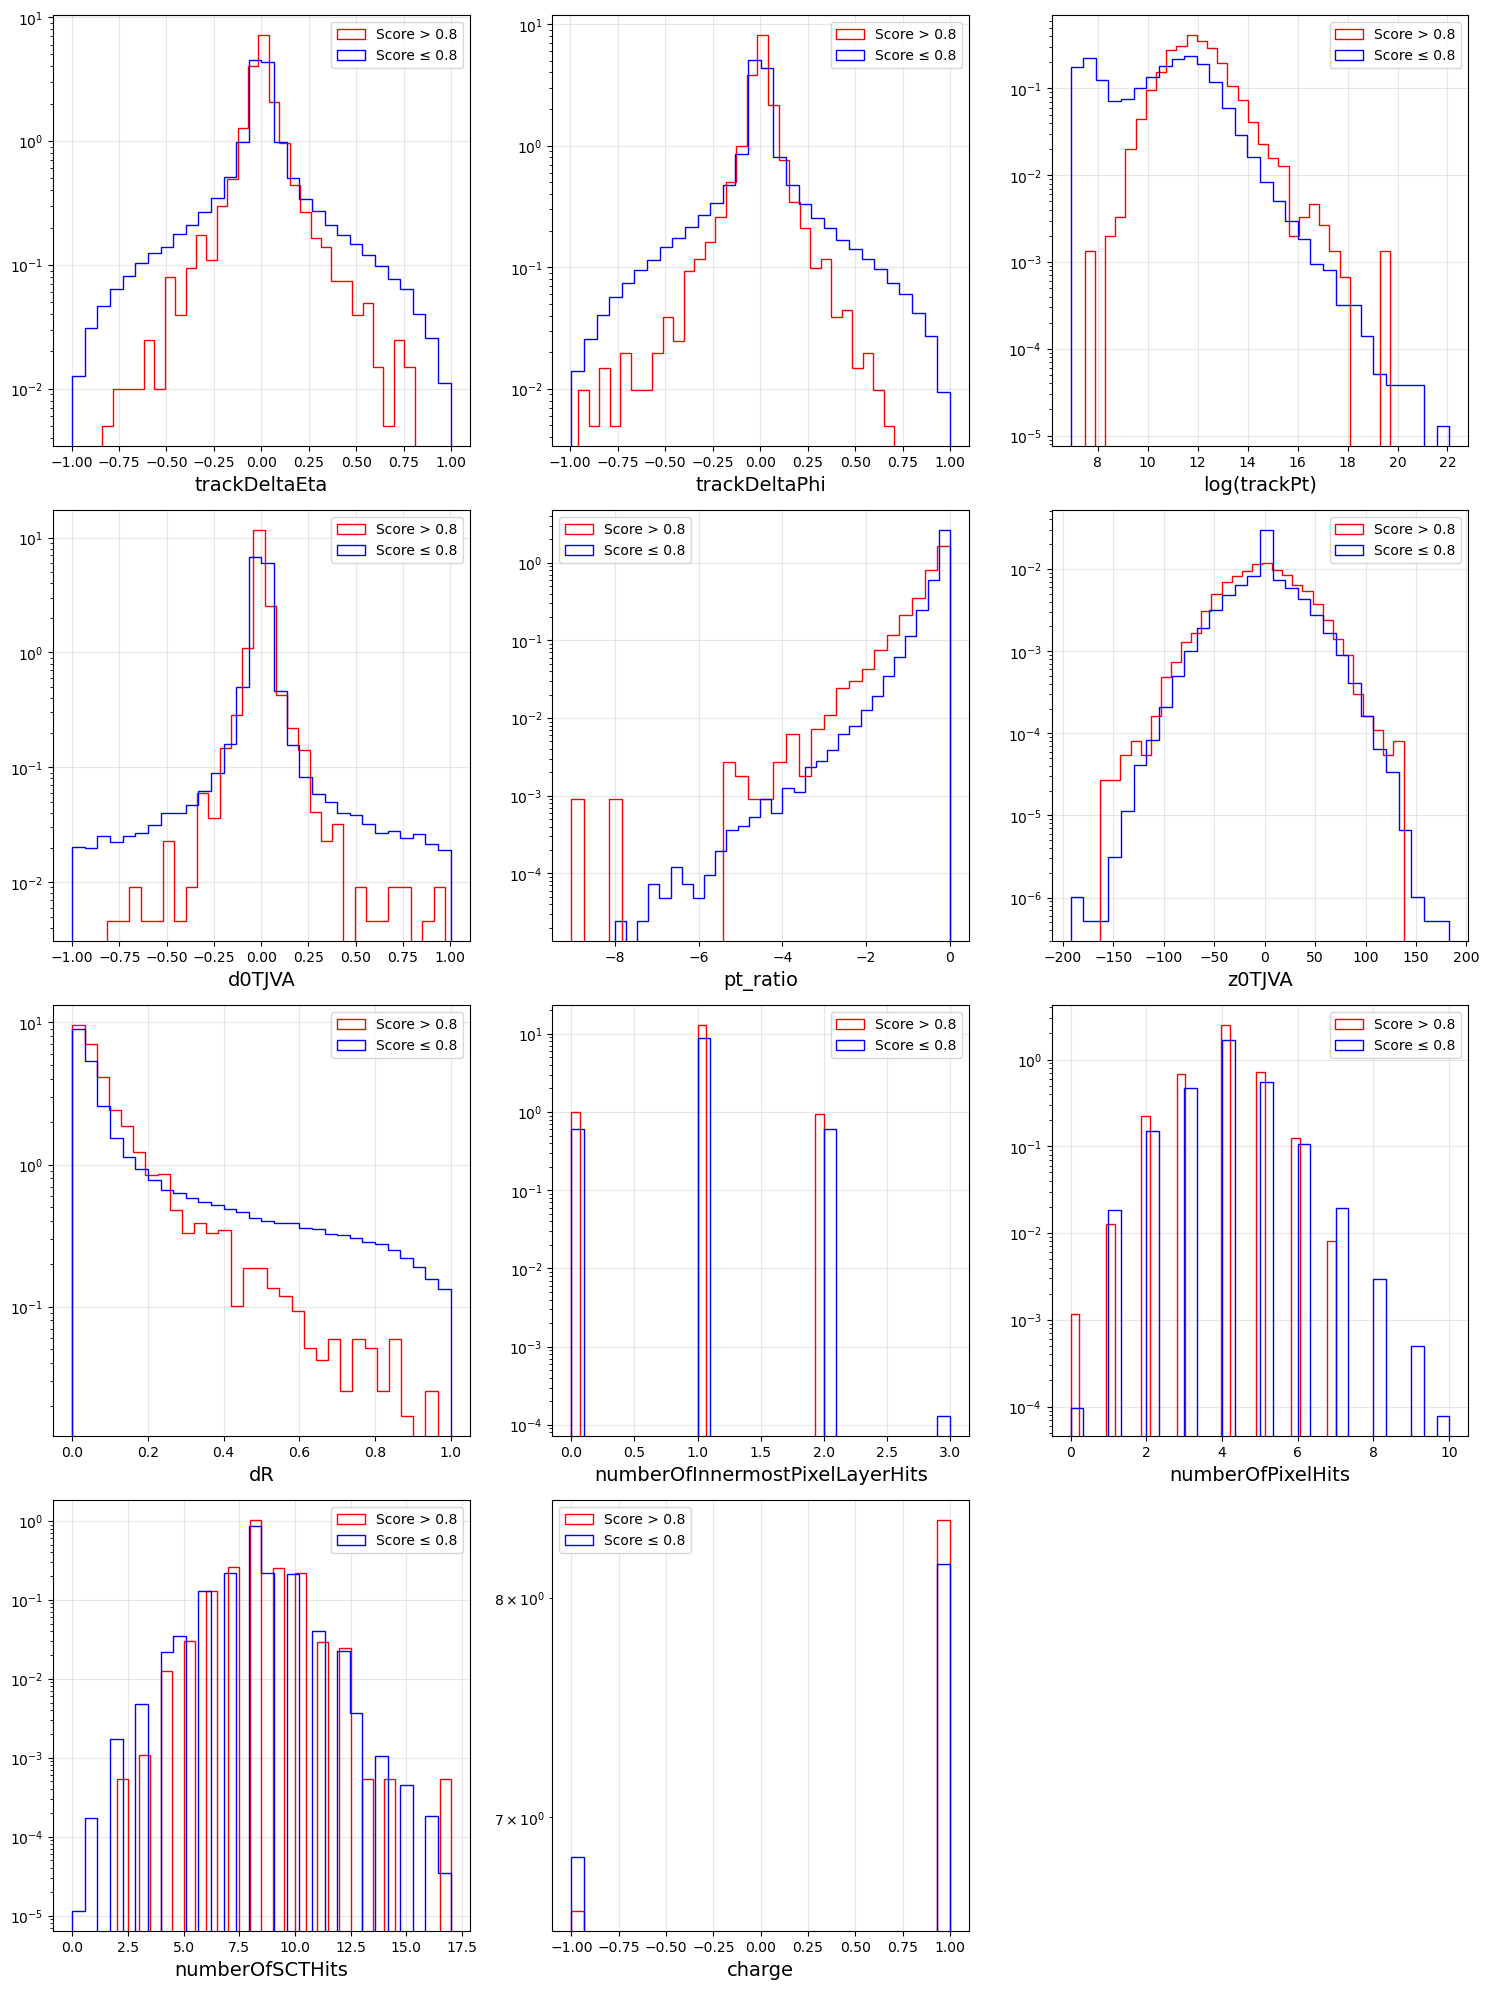

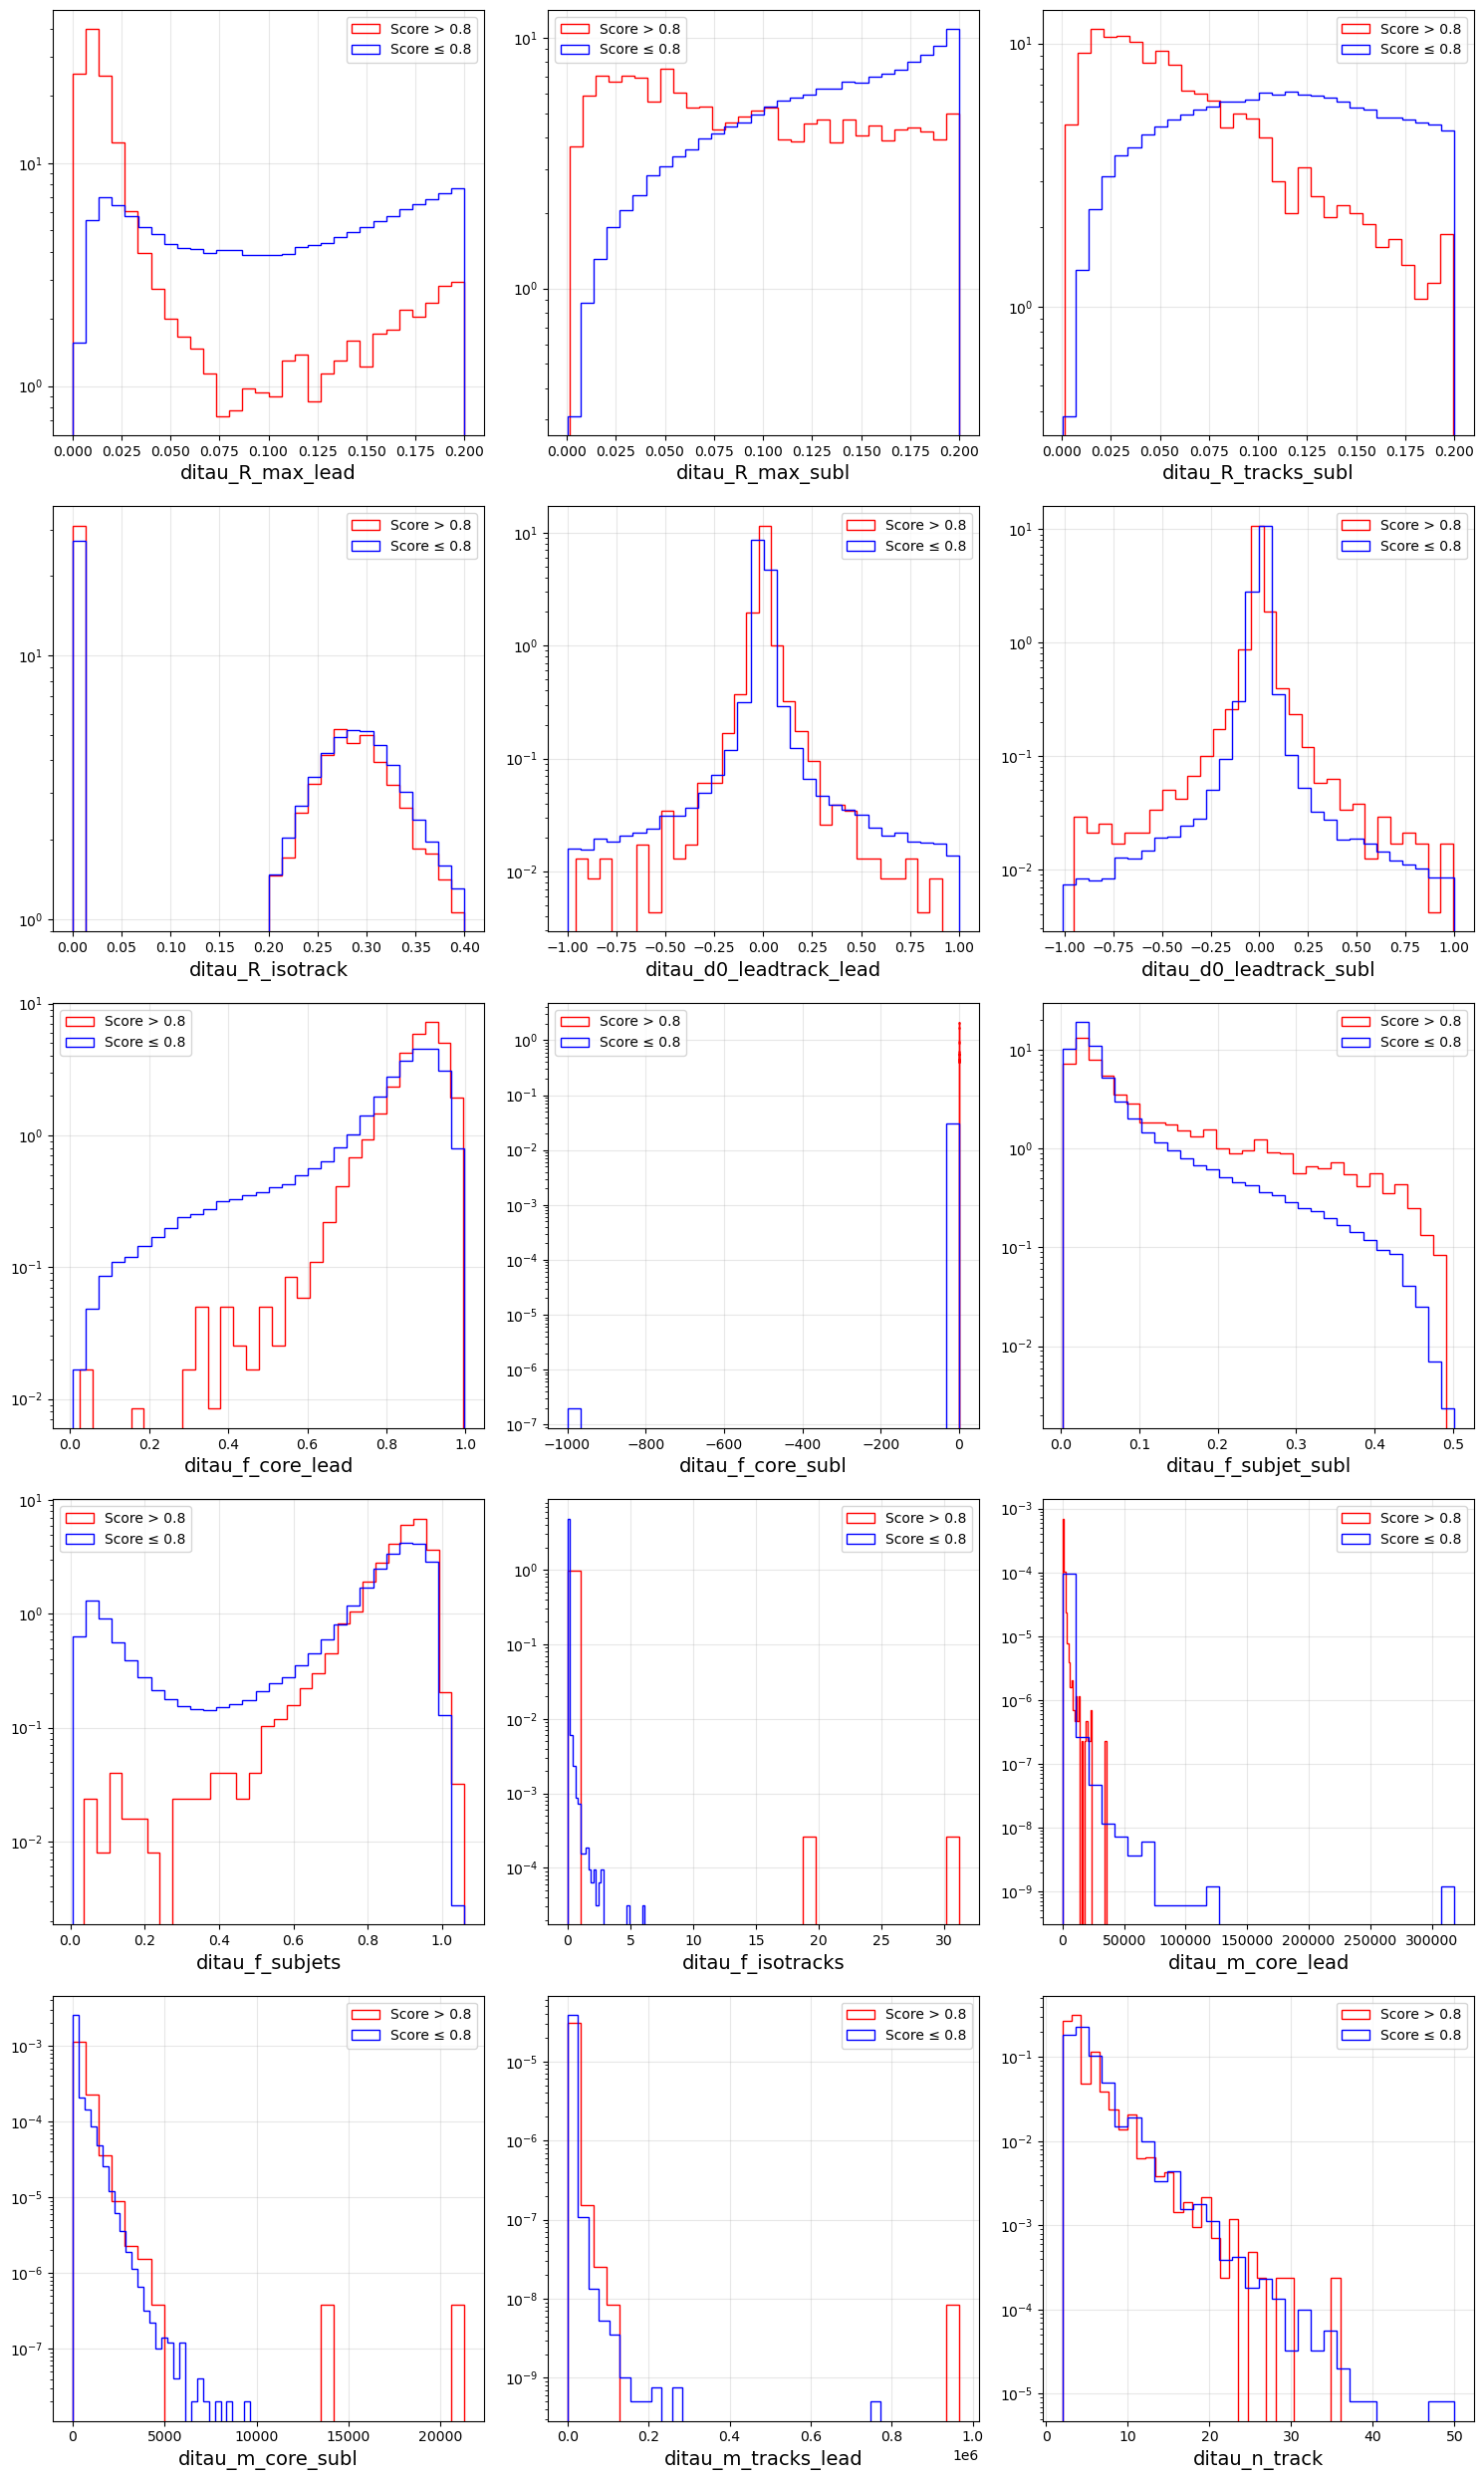

In [3]:
# Load prediction data
pred_path = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/"
pred_filename = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
data = np.load(pred_path + pred_filename, allow_pickle=True).item()

# Load training data
train_path = "/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/"
train_filename = "test_tau.h5"
train_data = h5py.File(train_path + train_filename, 'r')

# Get event IDs from both datasets
events_pred = data['event_id'].astype(int)
events_train = train_data['jet'][:, 0].astype(int)  # First feature of jet is event ID

# Create dictionaries mapping event IDs to indices
event_to_idx = {int(event_id): idx for idx, event_id in enumerate(events_pred)}
train_event_to_idx = {int(event_id): idx for idx, event_id in enumerate(events_train)}

# Get indices of matched events
matched_indices = []
train_indices = []
for event_id in events_pred:
    if int(event_id) in train_event_to_idx:
        matched_indices.append(event_to_idx[int(event_id)])
        train_indices.append(train_event_to_idx[int(event_id)])

# Convert to numpy arrays for easier indexing
matched_indices = np.array(matched_indices)
train_indices = np.array(train_indices)

# Print diagnostic information
print("Shape of prediction events:", events_pred.shape)
print("Shape of training events:", events_train.shape)
print("Number of matched events:", len(matched_indices))

jet_feature_names = [
    'ditau_R_max_lead', 'ditau_R_max_subl', 'ditau_R_tracks_subl',
    'ditau_R_isotrack', 'ditau_d0_leadtrack_lead', 'ditau_d0_leadtrack_subl',
    'ditau_f_core_lead', 'ditau_f_core_subl', 'ditau_f_subjet_subl',
    'ditau_f_subjets', 'ditau_f_isotracks', 'ditau_m_core_lead',
    'ditau_m_core_subl', 'ditau_m_tracks_lead', 'ditau_n_track'
]

track_feature_names = [
    'trackDeltaEta', 'trackDeltaPhi', 'log(trackPt)', 'd0TJVA', 
    'pt_ratio', 'z0TJVA', 'dR', 'numberOfInnermostPixelLayerHits',
    'numberOfPixelHits', 'numberOfSCTHits', 'charge'
]

# Get scores and create masks for high/low scoring events
y_scores = data['pred'][:, 1]
y_true = np.argmax(data['y'], axis=1)

# Create masks for background events (y_true == 0) with high/low scores
background_mask = y_true == 0
high_score_mask = (y_scores > 0.8) & background_mask
low_score_mask = (y_scores <= 0.8) & background_mask


def plot_feature_distributions(features, high_mask, low_mask, title, feature_names, skip_first=False):
    n_features = features.shape[1] - 1 if skip_first else features.shape[1]
    start_idx = 1 if skip_first else 0
    
    n_rows = (n_features + 2) // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.ravel()
    
    # print(f"Plotting {n_features} features starting from index {start_idx}")
    
    for i in range(n_features):
        feature_idx = i + start_idx
        
        high_vals = features[matched_indices[high_mask[matched_indices]], feature_idx]
        low_vals = features[matched_indices[low_mask[matched_indices]], feature_idx]
        
        axes[i].hist([high_vals], bins=30, label=['Score > 0.8'], 
                    histtype='step', density=True, color=['red'])
        axes[i].hist([low_vals], bins=30, label=['Score ≤ 0.8'], 
                    histtype='step', density=True, color=['blue'])
        
        high_mean, high_std = np.mean(high_vals), np.std(high_vals)
        low_mean, low_std = np.mean(low_vals), np.std(low_vals)
        
        feature_name = feature_names[i]
        # axes[i].set_title(f'{feature_name}\nHigh: μ={high_mean:.2f}, σ={high_std:.2f}\nLow: μ={low_mean:.2f}, σ={low_std:.2f}')
        axes[i].set_xlabel(feature_name, fontsize=14)
        axes[i].set_yscale('log')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
    
    # plt.suptitle(title)
    plt.tight_layout()
    return fig

# Print shapes before plotting
print("\nData features shape:", train_data['data'][:].shape)
print("Jet features shape:", train_data['jet'][:].shape)

# Plot data features (11 features)
print("\nPlotting data features...")
data_features = train_data['data'][:, 0, :]
fig1 = plot_feature_distributions(
    data_features, 
    high_score_mask[matched_indices], 
    low_score_mask[matched_indices], 
    'Data Features Distribution (Background Events)',
    track_feature_names
)

# Plot jet features (15 features, excluding first one which is event ID)
print("\nPlotting jet features...")
jet_features = train_data['jet'][:]
fig2 = plot_feature_distributions(
    jet_features, 
    high_score_mask[matched_indices], 
    low_score_mask[matched_indices], 
    'Jet Features Distribution (Background Events)',
    jet_feature_names,
    skip_first=True  # Skip the first feature as it's the event ID
)

# Save plots
# fig1.savefig('data_features_comparison.png')
# fig2.savefig('jet_features_comparison.png')

# Print summary statistics
n_total = np.sum(background_mask)
n_high = np.sum(high_score_mask)
n_low = np.sum(low_score_mask)

print("\nSummary Statistics:")
print(f"Total background events: {n_total}")
print(f"High-scoring events (>0.8): {n_high} ({n_high/n_total*100:.2f}%)")
print(f"Low-scoring events (≤0.8): {n_low} ({n_low/n_total*100:.2f}%)")

plt.show()

Selected 102960 events out of 1029602 matching events
Common events: 102722
ONNX scores before masking: 102960
Common events: 102722
ONNX scores after masking: 102960
NPY scores after masking: 102722
Event IDs match: False

Score Statistics:
ONNX scores - mean: 0.9895, std: 0.0761
NPY scores  - mean: 0.9894, std: 0.0764


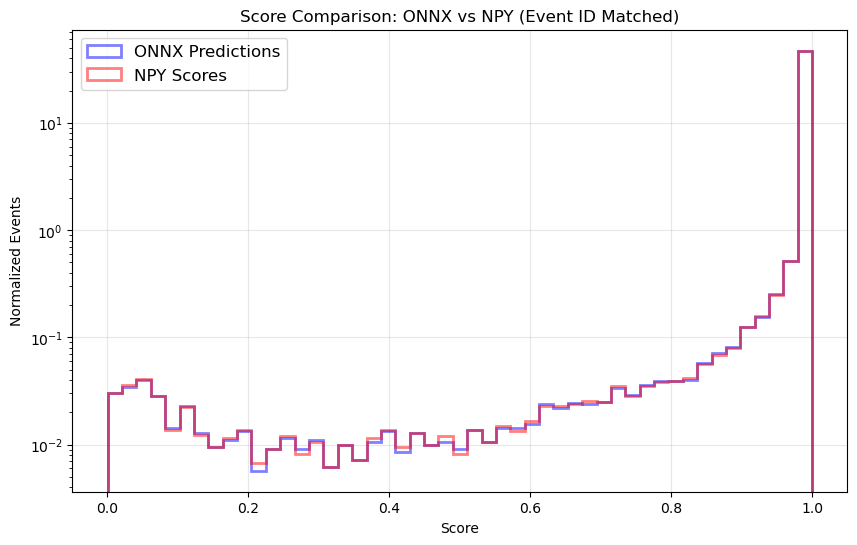

In [7]:
def pad_array(X, num_pad):
    """Pad the array to match TensorFlow preprocessing."""
    current_shape = X.shape[1]
    if current_shape >= num_pad:
        return X[:, :num_pad, :]
    else:
        pad_width = ((0, 0), (0, num_pad - current_shape), (0, 0))
        return np.pad(X, pad_width, mode='constant')

def read_h5_data(filename, npy_event_ids, data_fraction=0.1):
    """Read H5 data, ensuring consistent event matching with NPY data."""
    with h5py.File(filename, 'r') as f:
        X = np.array(f['data'], dtype=np.float32)
        jet_data = np.array(f['jet'], dtype=np.float32)
        pids = np.array(f['pid'])
        
        # Filter valid events (pid == 0)
        valid_mask = (pids == 1)
        valid_indices = np.where(valid_mask)[0]
        
        # Get base event information
        event_ids = jet_data[valid_indices, 0].astype(int)
        jet_features = jet_data[valid_indices, 1:]
        track_features = X[valid_indices]
        mask = X[:,:,2] != 0
        event_masks = mask[valid_indices]
        
        # Find matching events between NPY and H5
        npy_events_set = set(npy_event_ids.astype(int))
        matching_indices = np.array([i for i, event_id in enumerate(event_ids) 
                                   if event_id in npy_events_set])
        
        # Get total number of matching events
        num_matching_events = len(matching_indices)
        num_events_to_keep = int(num_matching_events * data_fraction)
        
        # Use fixed seed for reproducibility
        np.random.seed(42)
        selected_indices = np.random.choice(matching_indices, 
                                          num_events_to_keep, 
                                          replace=False)
        selected_indices.sort()  # Ensure consistent ordering
        
        # Extract final features
        track_features = track_features[selected_indices]
        jet_features = jet_features[selected_indices]
        columns_to_modify = [3, 4, 5, 6, 7]
        # Replace 0 values with -1234 in specified columns
        for col in columns_to_modify:
            jet_features[:, col][jet_features[:, col] == 0] = -1234
        # jet_features = np.delete(jet_features, [3, 4, 5, 6, 7], axis=1)
        event_ids = event_ids[selected_indices]
        event_masks = event_masks[selected_indices]
        
    print(f"Selected {num_events_to_keep} events out of {num_matching_events} matching events")
    return track_features, jet_features, event_ids, event_masks

# Rest of the code remains same...
def prepare_features_for_onnx(track_features, jet_features, mask, num_pad=10):
    """Prepare features for ONNX model inference."""
    track_features = pad_array(track_features, num_pad)
    time = np.zeros((jet_features.shape[0], 1), dtype=np.float32)
    
    return {
        'input_features': track_features,
        'input_points': track_features[:, :, :2],
        'input_mask': mask[:, :num_pad].astype(np.float32),
        'input_jet': jet_features.astype(np.float32),
        'input_time': time
    }

# Load NPY data
npy_path = "/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/"
npy_filename = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
# npy_filename = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights_good_no_weights.npy"

h5_file = '/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/test_tau.h5'
onnx_model = '/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/model.onnx'


# 1. Load NPY data and get event IDs for valid events (y_true == 0)
npy_data = np.load(npy_path + npy_filename, allow_pickle=True).item()
npy_scores = npy_data['pred'][:, 1]
npy_y_true = np.argmax(npy_data['y'], axis=1)
npy_event_ids = npy_data['event_id'][npy_y_true == 1].flatten()
npy_scores = npy_scores[npy_y_true == 1]

# 2. Load H5 data with matching
track_features, jet_features, h5_event_ids, masks = read_h5_data(h5_file, npy_event_ids, data_fraction=0.1)

# 3. Run ONNX inference
onnx_inputs = prepare_features_for_onnx(track_features, jet_features, masks)
session = ort.InferenceSession(onnx_model)
onnx_scores = session.run(None, onnx_inputs)[0][:, 1]


# 2. Create ordered event mapping
common_events = np.array(sorted(list(set(h5_event_ids.astype(int)) & set(npy_event_ids.astype(int)))))

# 3. Create masks using np.isin for exact matching
h5_mask = np.isin(h5_event_ids.astype(int), common_events)
npy_mask = np.isin(npy_event_ids.astype(int), common_events)
print(f"Common events: {len(common_events)}")
print(f"ONNX scores before masking: {len(onnx_scores)}")

# 4. Apply masks and verify shapes
onnx_scores = onnx_scores[h5_mask]
matched_npy_scores = npy_scores[npy_mask]

# 5. Validation
print(f"Common events: {len(common_events)}")
print(f"ONNX scores after masking: {len(onnx_scores)}")
print(f"NPY scores after masking: {len(matched_npy_scores)}")
print(f"Event IDs match: {np.array_equal(h5_event_ids[h5_mask], npy_event_ids[npy_mask])}")

# Plot results
plt.figure(figsize=(10, 6))
bins = np.linspace(min(min(onnx_scores), min(matched_npy_scores)),
                   max(max(onnx_scores), max(matched_npy_scores)), 
                   50)
plt.hist(onnx_scores, bins=bins, alpha=0.5, 
         label='ONNX Predictions',
         color='blue', density=True, histtype='step', linewidth=2)
plt.hist(matched_npy_scores, bins=bins, alpha=0.5, 
         label='NPY Scores',
         color='red', density=True, histtype='step', linewidth=2)
plt.yscale('log')
plt.ylabel('Normalized Events')
plt.xlabel('Score')
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)
plt.title('Score Comparison: ONNX vs NPY (Event ID Matched)')

# Print statistics
print("\nScore Statistics:")
print(f"ONNX scores - mean: {np.mean(onnx_scores):.4f}, std: {np.std(onnx_scores):.4f}")
print(f"NPY scores  - mean: {np.mean(matched_npy_scores):.4f}, std: {np.std(matched_npy_scores):.4f}")


H5 data loaded: 62704 events

Shape Information:
Track features shape: (62704, 10, 11)
Jet features shape: (62704, 15)
Mask shape: (62704, 10)
Time tensor shape: (62704, 1)
Number of ONNX scores: 62704

Score Statistics:
ONNX scores - mean: 0.8780, std: 0.3066


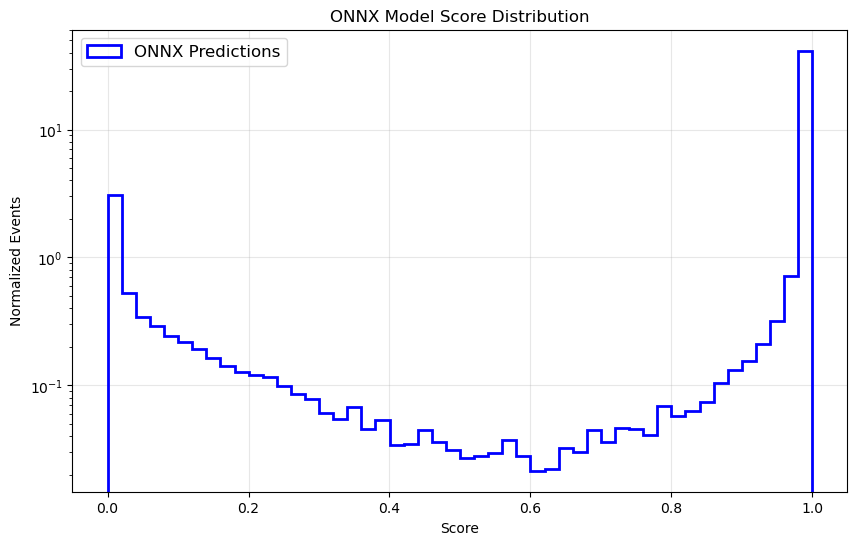

In [2]:


def pad_array(X, num_pad):
    """Pad the array to match TensorFlow preprocessing."""
    current_shape = X.shape[1]
    if current_shape >= num_pad:
        return X[:, :num_pad, :]
    else:
        pad_width = ((0, 0), (0, num_pad - current_shape), (0, 0))
        return np.pad(X, pad_width, mode='constant')

# def read_h5_data(filename):
#     """Read H5 data without any filtering."""
#     with h5py.File(filename, 'r') as f:
#         # Load all data
#         X = np.array(f['data'], dtype=np.float32)
#         jet_data = np.array(f['jet'], dtype=np.float32)
        
#         # Create mask based on third feature
#         mask = X[:,:,2] != 0
        
#         # Get features
#         track_features = X
#         jet_features = jet_data[:, 1:]  # Exclude event ID column
#         event_masks = mask
        
#     print(f"H5 data loaded: {len(track_features)} events")
#     return track_features, jet_features, event_masks

def read_h5_data(filename):
    """Read H5 data and return 30% random sample."""
    with h5py.File(filename, 'r') as f:
        # Load all data
        X = np.array(f['data'], dtype=np.float32)
        jet_data = np.array(f['jet'], dtype=np.float32)
        
        # Calculate number of events to keep (30%)
        n_events = X.shape[0]
        n_keep = int(n_events * 0.05)
        
        # Randomly select indices
        np.random.seed(42)  # for reproducibility
        keep_indices = np.random.choice(n_events, n_keep, replace=False)
        
        # Create mask based on third feature
        mask = X[:,:,2] != 0
        
        # Get features using selected indices
        track_features = X[keep_indices]
        jet_features = jet_data[keep_indices, 1:]  # Exclude event ID column
        event_masks = mask[keep_indices]
        
    print(f"H5 data loaded: {len(track_features)} events")
    return track_features, jet_features, event_masks


def prepare_features_for_onnx(track_features, jet_features, mask, num_pad=10):
    """Prepare features for ONNX model inference."""
    track_features = pad_array(track_features, num_pad)
    time = np.zeros((jet_features.shape[0], 1), dtype=np.float32)
    
    return {
        'input_features': track_features,
        'input_points': track_features[:, :, :2],
        'input_mask': mask[:, :num_pad].astype(np.float32),
        'input_jet': jet_features.astype(np.float32),
        'input_time': time
    }

def evaluate_onnx_model(model_path, inputs):
    """Run inference using ONNX model."""
    session = ort.InferenceSession(model_path)
    predictions = session.run(None, inputs)[0]
    return predictions[:, 1]

# Load H5 data
h5_file = '/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/test_tau.h5'
track_features, jet_features, masks = read_h5_data(h5_file)

# Prepare ONNX inputs
onnx_inputs = prepare_features_for_onnx(track_features, jet_features, masks)

# Run ONNX inference
onnx_model = '/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/model.onnx'
onnx_scores = evaluate_onnx_model(onnx_model, onnx_inputs)

# Print shape information
print("\nShape Information:")
print(f"Track features shape: {track_features.shape}")
print(f"Jet features shape: {jet_features.shape}")
print(f"Mask shape: {masks.shape}")
print(f"Time tensor shape: {onnx_inputs['input_time'].shape}")
print(f"Number of ONNX scores: {len(onnx_scores)}")

# Plot score distribution
plt.figure(figsize=(10, 6))
plt.hist(onnx_scores, bins=50, 
         label='ONNX Predictions',
         color='blue', density=True, histtype='step', linewidth=2)
plt.yscale('log')
plt.ylabel('Normalized Events')
plt.xlabel('Score')
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)
plt.title('ONNX Model Score Distribution')

# Print score statistics
print("\nScore Statistics:")
print(f"ONNX scores - mean: {np.mean(onnx_scores):.4f}, std: {np.std(onnx_scores):.4f}")